<a href="https://colab.research.google.com/github/xunxunshi/Passage_Clustering/blob/main/Passage_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
__author__="Xun Xun, Tulika, Lasya" 
import seaborn as sns
import pandas as pd  
import re 
import wordcloud
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from collections import Counter
from numpy.random import default_rng
import spacy
from nltk.corpus import gutenberg
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report
from scipy.sparse import csr_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn import metrics 
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
from sklearn.mixture import GaussianMixture
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:

from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# download gutenberg to access the digital text books
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [ ]:
def returnLabeledBook(text, bookName,wordsInpassage):
    Counter=0
    doc=word_tokenize(text)
    BookDf=pd.DataFrame(columns={'passage'})
    while((Counter+wordsInpassage+1)<len(doc)):
        
        tempdoc=" ".join(str(item) for item in doc[Counter:wordsInpassage+Counter])

        lengthOfNonWords=len(re.findall(r'\W\s+',tempdoc)) ## length of anything that is not a word or punctuation in the first 100 tokens
        ## i.e if there are 20 tokens that are punctuations out of 100, we should add another 20 tokens
        if((wordsInpassage+Counter+lengthOfNonWords)<len(doc)):
            # we do additional check to see how many punctuations are there in these additional tokens
            additionalWord=" ".join(str(item) for item in doc[wordsInpassage+Counter:wordsInpassage+Counter+lengthOfNonWords])
            lengthofNonwordsInAdditional=len(re.findall(r'\W\s+',additionalWord))
            if((wordsInpassage+Counter+lengthOfNonWords+lengthofNonwordsInAdditional)<len(doc)):
                
                asjustedDoc=" ".join(str(item) for item in doc[Counter:wordsInpassage+Counter+lengthOfNonWords+lengthofNonwordsInAdditional])
                BookDf.loc[len(BookDf)]=asjustedDoc
                Counter=Counter+lengthOfNonWords+wordsInpassage+lengthofNonwordsInAdditional
            else:
                break
        else:
            break
    BookDf['bookName']=bookName
    if(len(BookDf)<200): ## if there is less than 200 partions 
        print('Warning: The book has less than 20000 words and can not be split into a passage of 200 parts of'+ str(wordsInpassage)+'words.')
        return BookDf
    else:
        rng=default_rng() 
        numbers=rng.choice(len(BookDf),size=200,replace=False)
        print('We have succesfully partioned your book '+bookName+' into 200 random partitions of'+ str(wordsInpassage) +'words each. \n')
        print('Please note that there was a total of '+str(len(BookDf))+' partitions available, and the dataframe index represents the ordered part that were taken out. ')
        return BookDf.iloc[numbers] 

In [ ]:

df1=pd.DataFrame()
 
df1= returnLabeledBook(nltk.corpus.gutenberg.raw('chesterton-thursday.txt'),'chesterton-thursday',150)
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('melville-moby_dick.txt'), 'moby_dick',150))
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('shakespeare-hamlet.txt'), 'shakespeare-hamlet',150))
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('bryant-stories.txt'),'bryant-stories',150))
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('milton-paradise.txt'),'milton-paradise',150))

We have succesfully partioned your book chesterton-thursday into 200 random partitions of150words each. 

Please note that there was a total of 391 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book moby_dick into 200 random partitions of150words each. 

Please note that there was a total of 1446 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book shakespeare-hamlet into 200 random partitions of150words each. 

Please note that there was a total of 201 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book bryant-stories into 200 random partitions of150words each. 

Please note that there was a total of 311 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book

In [ ]:
#df1.to_excel('books.xlsx')

### Please specify the path (where the books.xlsx file is) in the code below. If running on google colab please upload books.xlsx file to the session storage as mentioned in read me.

In [ ]:
df1=pd.read_excel('books.xlsx')

In [ ]:
df1

Unnamed: 0  ...             bookName
0            72  ...  chesterton-thursday
1           172  ...  chesterton-thursday
2           148  ...  chesterton-thursday
3            10  ...  chesterton-thursday
4           156  ...  chesterton-thursday
..          ...  ...                  ...
995         115  ...      milton-paradise
996         355  ...      milton-paradise
997         118  ...      milton-paradise
998          11  ...      milton-paradise
999         434  ...      milton-paradise

[1000 rows x 3 columns]

In [ ]:
df1.groupby('bookName').count()

Unnamed: 0  passage
bookName                                
bryant-stories              200      200
chesterton-thursday         200      200
milton-paradise             200      200
moby_dick                   200      200
shakespeare-hamlet          200      200

# Data Preprocessing and cleansing: 
### Getting rid of the punctuations and Spacy Lemmatization 


*  Our choice of Spacy libary was motivated by the fact that it can perform tokenization in 0.2 milliseconds compared to nltk's 4 milliseconds.
* We are performing a lemmatization in the below code. It is a process of converting many different forms to it's root word. For example, words such as building, built, build etc will be converted  to its base form or lemma 'build', based on the context of the words surrounding it. 
* The nlp pipeline created using Spacy will automatically perform the tokenization, parsing and tagging processes for us.
* We have reran this code without these preprocessing step which lead to lower accuracy. 
* We are not removing stopwords during preprocessing because these features assists in adding context to the classification. Because our data contains past century books such as Shakespeare's Hamlet, the common language are different then than modern books. Thhese stopwords could serve as key feature to help distinguish these differences. Removing them could potentially reduce the accuracy of the model in classifying such books.


#### Getting rid of punctuations 

In [ ]:
def return_split(passage):
  return (re.sub(r'[^\w\s]', '', str(passage).lower().strip()))

In [ ]:
df1['passage']=df1['passage'].apply(return_split)

In [ ]:
nlp=spacy.load('en_core_web_sm')

#### Lemmatization

In [ ]:
def lemmatization(x):
  X_list=[]
  for token in nlp(x):
    lemma=token.lemma_
    X_list.append(lemma)
  return " ".join(X_list)

In [ ]:
def lemmatization_LDA(x):
  X_list=[]
  for token in nlp(x):
    lemma=token.lemma_
    X_list.append(lemma)
  return X_list

In [ ]:
x_LDA=df1['passage'].apply(lemmatization_LDA)

In [ ]:
df1['passage']=df1['passage'].apply(lemmatization)

######  We use clustering algorithms on the x data to generate labels.
We hold out the y to compare with the clustered labels for evaluation. 

In [ ]:
x=df1['passage']
y=df1['bookName']

# Feature Engineering:  



### TF-IDF
As a first choice, we are using TF-IDF to transform our X (Passages) into vectors 
* TF-IDF is a vectorization algorithm which is used to represent textual data in numerical vectors . It gives weights to the words depending on their frequency. 
* Compared to bag of words, TF-IDF also calculates the inverse document frequency, which will factor in the frequency of the word to occur in all documents. This will take out very commonly used words. 
* The 'Fit' is used to identify the vocabulary and frequency whereas the 'Transform' is used for conversion to a vector.

In [ ]:
vec = TfidfVectorizer(binary=True, use_idf=True)
tfidf_train_data = vec.fit_transform(x)  

### Bag of words:
* Bag of words is a form of vectorization process for extracting features from the textual data. Like Tf-idf, this is another step of feature processing, but it does not take into account how often the words will appear across different documents. 
* The term 'bag' implies that the order of the words appearing in the document is ignored. The model is only concerned with whether the word is present in a document, not with the location of the word in the document.


In [ ]:
vec = CountVectorizer(binary=True)
Bow_train_data = vec.fit_transform(x)  

### Word2Vec:
* Word 2 vec trains a neural network to process text into a vector output 
* This can be achieved using either continous bag of word or skipgram 
 


#### To load the following package for lemmentization on google colllab, please follow this tutorial 
[Load-spacy_model_en_core_web_lg-on-google-collab](https://medium.com/@icetutor/unable-to-load-the-spacy-model-en-core-web-lg-on-google-colab-af43679dd0b5)



In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [ ]:
temp=[]
for i in range(0,len(x)):
    doc = nlp(x[i]).vector
    temp.append(doc)

In [ ]:
x_word_2_vec= np.array(temp)
x_word_2_vec.shape

(1000, 300)

### Dimentionality reduction using PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=300) 
X_train_tfidf_pca = pca.fit_transform(tfidf_train_data.toarray())
X_train_bow_pca = pca.fit_transform(Bow_train_data.toarray())

#LDA with Coherence score 

In [ ]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary
# Create Dictionary, note that we also tried this with the common dirctionary but get an error because certains words were not included 
id2word = corpora.Dictionary(x_LDA)
# Create Corpus
texts = x_LDA
# Term Document Frequency
BoWcorpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
import gensim
def plotCoherenceScoreWithK(corpus_value,title):
  coherence_score=[]
  topics=[]
  for K in range(1,9): 
    lda_model = gensim.models.LdaModel(corpus=corpus_value,
                                          id2word=id2word,
                                          num_topics=K, 
                                          random_state=100)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=x_LDA, dictionary=id2word, coherence='c_v')
    coherence_score.append(coherence_model_lda.get_coherence())
    topics.append(K)
  plt.plot(topics,coherence_score)
  plt.ylabel('coherence')
  plt.xlabel('K')
  plt.title(title)

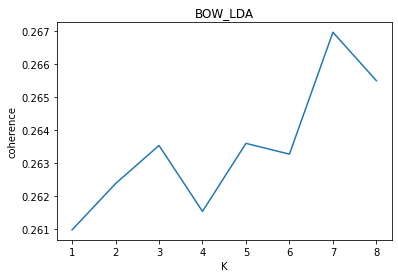

In [ ]:
plotCoherenceScoreWithK(BoWcorpus,'BOW_LDA')

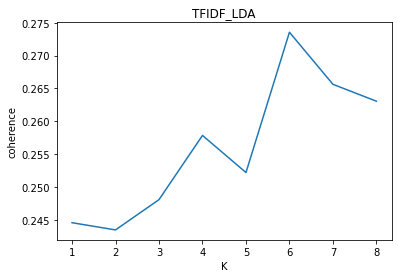

In [ ]:
from gensim.models import TfidfModel
model = TfidfModel(BoWcorpus)
TFIDFcorpus = model[BoWcorpus] 
plotCoherenceScoreWithK(TFIDFcorpus,'TFIDF_LDA')

# Different Functions for Visualization

In [ ]:
# for TFIDF:  x = tfidf_train_data
# for Bag of words : x=Bow_train_data
# for Word2Vec: x= w2V_train_data

In [ ]:
## Kmeans/ Hierachieal clustering/ EM model 

In [ ]:
def returnBookToCluster(df1,y_clusters):
    temp_df=df1.copy() 
    temp_df['y_cluster']=y_clusters
    bookLabels=df1['bookName'].unique()
    totalBookCluster=pd.DataFrame(columns=bookLabels)
    for clusters in temp_df['y_cluster'].unique():  
        totalBookCluster=totalBookCluster.append(temp_df[temp_df['y_cluster']==clusters].groupby('bookName').count()[['passage']].T)
    totalBookCluster=totalBookCluster.fillna(0)
    totalBookCluster['clusterNum']=temp_df['y_cluster'].unique()
    totalBookCluster['cluster_label']=totalBookCluster.idxmax(axis=1)
    return(totalBookCluster.reset_index()[['bryant-stories', 'chesterton-thursday', 'milton-paradise', 'moby_dick','shakespeare-hamlet', 'clusterNum','cluster_label']])


In [ ]:
def return_cluster_y_emp(totalBookCluster,y_clusterdf,y):
    temp_dict= dict(totalBookCluster[['clusterNum','cluster_label']].to_dict('split')['data'])
    y_cluster_labels= np.vectorize(temp_dict.get)(y_clusterdf)
    y_corresp_label=pd.DataFrame({'cluster':y_cluster_labels,'empirical cluster':y['bookName'],'passage':y['passage']})
    return(y_corresp_label)

In [ ]:
def plot_clusters(cluster1,cluster2,labeled_cluster_with_features,plot_title):
    for clusterNames in labeled_cluster_with_features['cluster'].unique():
        temp_cluster=labeled_cluster_with_features[labeled_cluster_with_features['cluster']==clusterNames]
        plt.scatter(temp_cluster.iloc[:,cluster1],temp_cluster.iloc[:,cluster2],label=clusterNames)
    plt.xlabel('component' +str(cluster1))
    plt.ylabel('component' +str(cluster2))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(plot_title)
    plt.show()
    

In [ ]:
def plot_confusion_matrix(y_test,pred,title):
    mat = confusion_matrix(y_test,pred)

    axes = sns.heatmap(mat,square=True, annot=True,fmt='d',
                       cbar=True, cmap=plt.cm.BrBG)

    class_labels = ['bryant-stories','carrol-alice','chesterton-thursday','milton-paradise','shakespeare-hamlet' ]

    axes.set_xlabel('Annotated Label from clusters')
    axes.set_ylabel('Empirical Labels')

    tick_marks = np.arange(len(class_labels)) + 0.5

    axes.set_xticks(tick_marks)
    axes.set_xticklabels(class_labels,rotation=90)

    axes.set_yticks(tick_marks)
    axes.set_yticklabels(class_labels,rotation=0)

    axes.set_title('Confusion Matrix:'+title)

In [ ]:
def plotInitialCluster(EM_cluster_agg,title):
    df_melt=EM_cluster_agg[['bryant-stories', 'chesterton-thursday', 'milton-paradise', 'moby_dick','shakespeare-hamlet','clusterNum']].melt(id_vars='clusterNum').rename(columns=str.title)
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(10, 4) 
    ax=sns.barplot(x='Clusternum', y='Value', hue='Variable', data=df_melt,  palette=["C2", "C1", "C3", "C0","C4"])
    ax.title.set_text('Initial Clusters:'+title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    EM_cluster_agg['clusterNum']=EM_cluster_agg['clusterNum'].astype(str)
    EM_cluster_agg['cluster_label_num']=EM_cluster_agg[['cluster_label','clusterNum']].agg('/'.join, axis=1)

    df_melt=EM_cluster_agg.sort_values(by='clusterNum')[['bryant-stories', 'chesterton-thursday', 'milton-paradise', 'moby_dick','shakespeare-hamlet','cluster_label_num']].melt(id_vars='cluster_label_num').rename(columns=str.title)
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(10, 4)
    ax=sns.barplot(x='Cluster_Label_Num', y='Value', hue='Variable', data=df_melt,  palette=["C2", "C1", "C3", "C0","C4"]) 
    ax.title.set_text('Cluster Assignment'+title)
    ax.legend(bbox_to_anchor=(1.05, 1))
    plt.show()
    
    EM_cluster_agg['clusterNum']=EM_cluster_agg['clusterNum'].astype(int)

In [ ]:
def return_list_ofErrors(y_correspond_label):
    totalListoferrors=pd.DataFrame(columns=['passage','cluster','empirical cluster'])
    for inputP, prediction, label in zip(y_correspond_label['passage'], y_correspond_label['cluster'], y_correspond_label['empirical cluster']):
        if prediction != label:
            listOfErrors=[inputP,prediction,label]
            totalListoferrors.loc[len(totalListoferrors)]=listOfErrors
    return(totalListoferrors)

In [ ]:
def plot_empirical_clusters(cluster1,cluster2,labeled_cluster_with_features,plot_title):
    dict_color={'chesterton-thursday':'#1f77b4', 'bryant-stories':'#d62728', 'moby_dick':'#ff7f0e',
       'milton-paradise':'#9467bd', 'shakespeare-hamlet':'#2ca02c'}
    for clusterNames in labeled_cluster_with_features['empirical cluster'].unique():
        temp_cluster=labeled_cluster_with_features[labeled_cluster_with_features['empirical cluster']==clusterNames]
        plt.scatter(temp_cluster.iloc[:,cluster1],temp_cluster.iloc[:,cluster2],label=clusterNames,color=dict_color[clusterNames])
    plt.xlabel('component' +str(cluster1))
    plt.ylabel('component' +str(cluster2))
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(plot_title)
    plt.show()

In [ ]:
def plot_clusters_Kmeans(cluster1,cluster2,labeled_cluster_with_features,plot_title,km):
    dict_color={'chesterton-thursday':'#1f77b4', 'bryant-stories':'#d62728', 'moby_dick':'#ff7f0e',
           'milton-paradise':'#9467bd', 'shakespeare-hamlet':'#2ca02c'}
    for clusterNames in labeled_cluster_with_features['cluster'].unique():
        temp_cluster=labeled_cluster_with_features[labeled_cluster_with_features['cluster']==clusterNames]
        plt.scatter(temp_cluster.iloc[:,cluster1],temp_cluster.iloc[:,cluster2],label=clusterNames,color=dict_color[clusterNames])
    plt.xlabel('component' +str(cluster1))
    plt.ylabel('component' +str(cluster2))
    centers = km.cluster_centers_
    plt.scatter(centers[:, cluster1], centers[:, cluster2], c='black', s=100, alpha=0.4)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(plot_title)
    plt.show()

# K-Means Clustering - TF-IDF (With PCA)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


### choosing an optimal K value, in case we do not know the number of clusters to create

In [ ]:
def elbow_for_k(x_train, methodName):
    K = range(2,10)
    sum_of_squared_distances = []
    for k in K:
        km = KMeans(n_clusters=k, max_iter=200, n_init=10)
        km = km.fit(x_train)
        sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, sum_of_squared_distances)
    plt.xlabel('K Values')
    plt.ylabel('Variation (within Cluster)')
    plt.title('Elbow method for Optimal K'+methodName)
    plt.show()

In [ ]:
def sihoutte_for_k(x_train, methodName):
  num_clusters = list (range(2,9))
  sihouttescore=[]
  for n_clusters in num_clusters:
      clusterer = KMeans(n_clusters=n_clusters)
      preds = clusterer.fit_predict(x_train)
      centers = clusterer.cluster_centers_
      sihouttescore.append(silhouette_score(x_train, preds))
  plt.plot(num_clusters,sihouttescore)
  plt.xlabel('cluster number')
  plt.ylabel('silhouette score')
  plt.title(methodName)

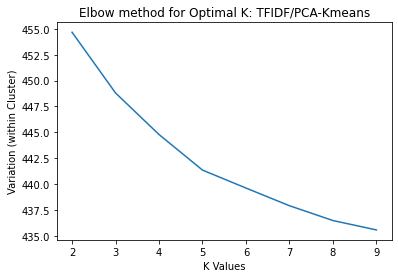

In [ ]:
elbow_for_k(X_train_tfidf_pca,': TFIDF/PCA-Kmeans')

The value of K, for which the variation within the clusters is minimized i.e the coherence within the cluster is maximized, is an ideal value for k. We can see from the above graph that the variation drastically dropped and stabilized when k = 5.
Hoewever, we already know that we need to divide the input passages from the dataset into 5 different clusters since we are aware that the passages are from five different books. The elbow method demonstrated above simply justified our value for k.

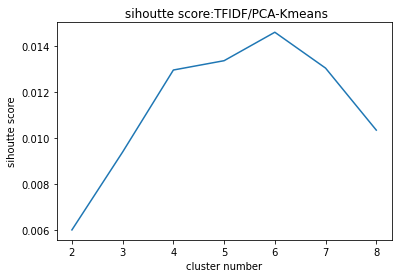

In [ ]:
sihoutte_for_k(X_train_tfidf_pca,' silhouette score:TFIDF/PCA-Kmeans')

### Building the model

we set the init parameter to k-means++ to ensure that the initialized centroids are as distant from each other as possible. This will reduce the number of iterations of the model before it reaches the correct centroid values.

In [ ]:
k = 5
km = KMeans(n_clusters=k, init='k-means++',max_iter=200, n_init=10,random_state=42)
km.fit_predict(X_train_tfidf_pca)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
pred_labels = km.labels_
pred_labels.shape

(1000,)

In [ ]:
TFIDF_KMeans_cluster=returnBookToCluster(df1,pred_labels)
TFIDF_KMeans_cluster

bryant-stories  chesterton-thursday  ...  clusterNum        cluster_label
0               4                  191  ...           0  chesterton-thursday
1               6                    4  ...           3            moby_dick
2             189                    4  ...           4       bryant-stories
3               1                    1  ...           2      milton-paradise
4               0                    0  ...           1   shakespeare-hamlet

[5 rows x 7 columns]

### Visualizing the clusters

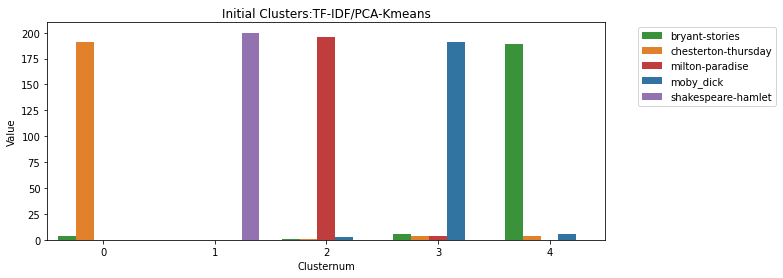

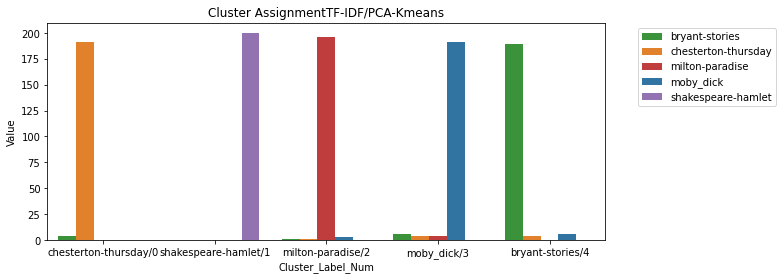

In [ ]:
plotInitialCluster(TFIDF_KMeans_cluster,'TF-IDF/PCA-Kmeans')

### Predicted and actual label association

In [ ]:
y_correspond_label=return_cluster_y_emp(TFIDF_KMeans_cluster,pred_labels,df1)
y_correspond_label

cluster  ...                                            passage
0    chesterton-thursday  ...  poet   -PRON- be really a poet who have become...
1    chesterton-thursday  ...  that when -PRON- break up rather hurriedly the...
2    chesterton-thursday  ...  as to send a lame man    -PRON- set off at a s...
3    chesterton-thursday  ...    gregory   upon the whole nature of poetry   ...
4    chesterton-thursday  ...  thread   -PRON- come nearer and near   the lam...
..                   ...  ...                                                ...
995      milton-paradise  ...  unexampled love   love no where to be find les...
996      milton-paradise  ...  then return at shut of evening flower   but   ...
997      milton-paradise  ...    to be deem a god   leap fondly into aetna fl...
998      milton-paradise  ...  -PRON- malice serve but to bring forth infinit...
999      milton-paradise  ...  the mouth of hell for ever   and seal up -PRON...

[1000 rows x 3 columns]

### Confusion Matrix

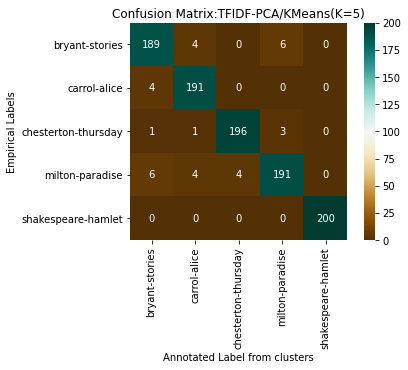

In [ ]:
 plot_confusion_matrix(y_correspond_label['cluster'],y_correspond_label['empirical cluster'],'TFIDF-PCA/KMeans(K=5)')

### Kappa Score

In [ ]:
cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])

0.95875

### Silhouette score and Analysis

In [ ]:
def silhouette_analysis(x_train,pred_labels,kmeans_cluster,methodName):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_train) + 60])
    silhouette_avg = silhouette_score(x_train, pred_labels)
    print("The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(x_train, pred_labels)
    y_lower = 10
    dict_color={'chesterton-thursday':'#1f77b4', 'bryant-stories':'#d62728', 'moby_dick':'#ff7f0e',
       'milton-paradise':'#9467bd', 'shakespeare-hamlet':'#2ca02c'}
    for i in range(5):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[pred_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = dict_color[kmeans_cluster[kmeans_cluster['clusterNum']==i]['cluster_label'].values[0]]
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)
        ax2.scatter(x_train[np.where(pred_labels==i),0], x_train[np.where(pred_labels==i),1], marker='.', s=30, lw=0, alpha=0.7,
                c=color, edgecolor='k')
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 
    ax1.set_title("The silhouette plot for"+methodName)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    centers = km.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the PC0 vs PC1:"+methodName)
    ax2.set_xlabel("Feature space for the 0th feature")
    ax2.set_ylabel("Feature space for the 1st feature")
    plt.show()

The average silhouette_score is : 0.013050367652141999


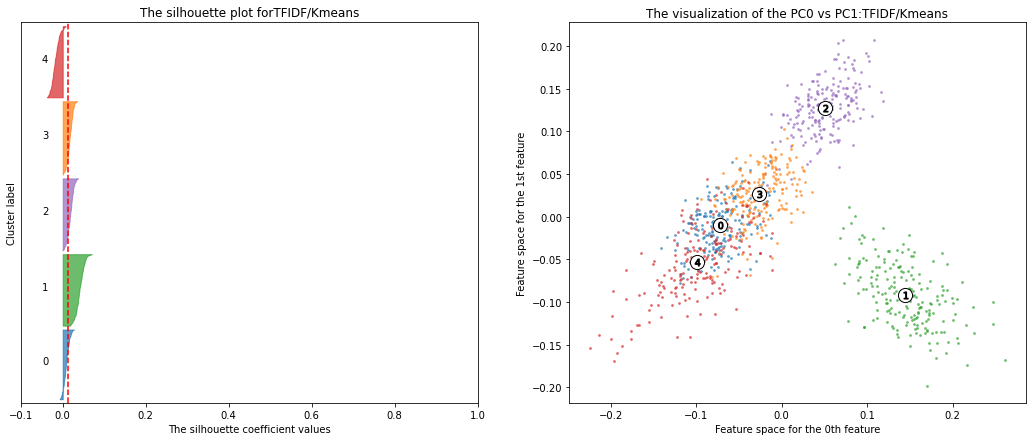

In [ ]:
silhouette_analysis(X_train_tfidf_pca, pred_labels,TFIDF_KMeans_cluster,'TFIDF/Kmeans')

### PCA Visualization

In [ ]:
pca.explained_variance_ratio_[0:4]

array([0.0168228 , 0.0141671 , 0.00805332, 0.00720148])

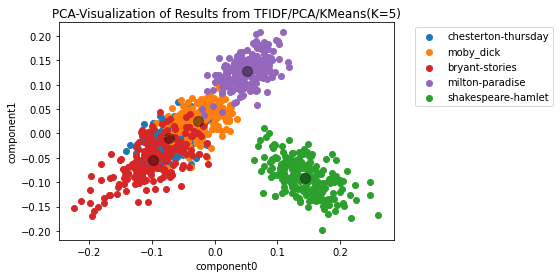

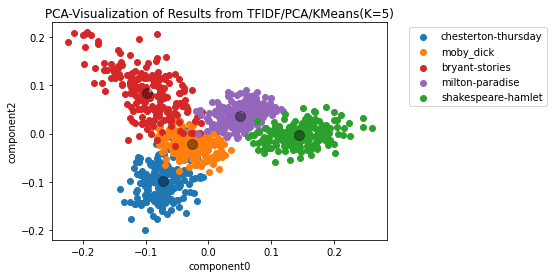

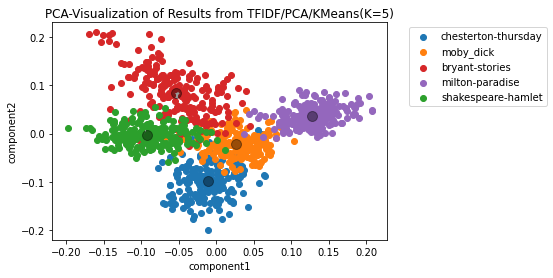

In [ ]:
tfidf_pca_visu=pd.DataFrame(X_train_tfidf_pca)
tfidf_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
plot_clusters_Kmeans(0,1,tfidf_pca_visu,'PCA-Visualization of Results from TFIDF/PCA/KMeans(K=5)',km)
plot_clusters_Kmeans(0,2,tfidf_pca_visu,'PCA-Visualization of Results from TFIDF/PCA/KMeans(K=5)',km)
plot_clusters_Kmeans(1,2,tfidf_pca_visu,'PCA-Visualization of Results from TFIDF/PCA/KMeans(K=5)',km)

### List of errors

In [ ]:
len(return_list_ofErrors(y_correspond_label))

36

# TFIDF- Kmeans (NO PCA)

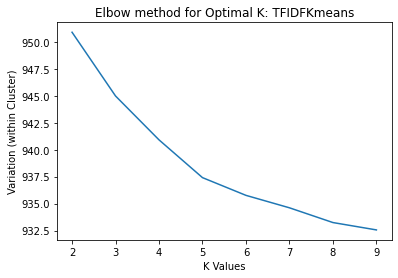

In [ ]:
elbow_for_k(tfidf_train_data,': TFIDFKmeans')

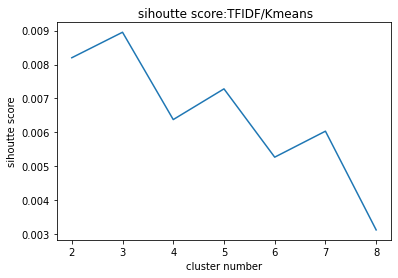

In [ ]:
sihoutte_for_k(tfidf_train_data,' sihoutte score:TFIDF/Kmeans')

In [ ]:
k = 5
km = KMeans(n_clusters=k, init='k-means++',max_iter=200, n_init=10,random_state=42)
km.fit_predict(tfidf_train_data)

array([0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
       4, 0, 3, 3, 3, 3, 3, 4, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 0,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [ ]:
pred_labels = km.labels_ 
TFIDF_KMeans_cluster=returnBookToCluster(df1,pred_labels) 


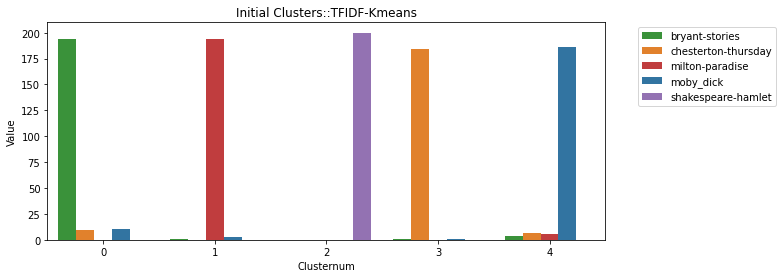

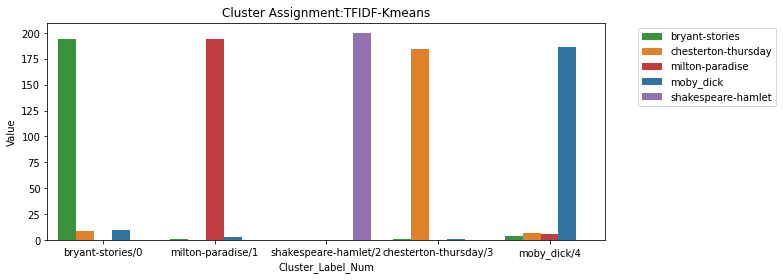

In [ ]:
plotInitialCluster(TFIDF_KMeans_cluster,':TFIDF-Kmeans')

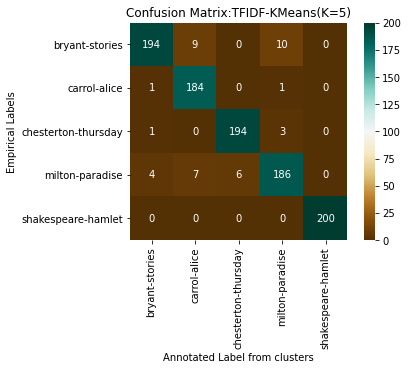

In [ ]:
y_correspond_label=return_cluster_y_emp(TFIDF_KMeans_cluster,pred_labels,df1)
plot_confusion_matrix(y_correspond_label['cluster'],y_correspond_label['empirical cluster'],'TFIDF-KMeans(K=5)')

In [ ]:
cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])

0.9475

The average silhouette_score is : 0.007523301962746982


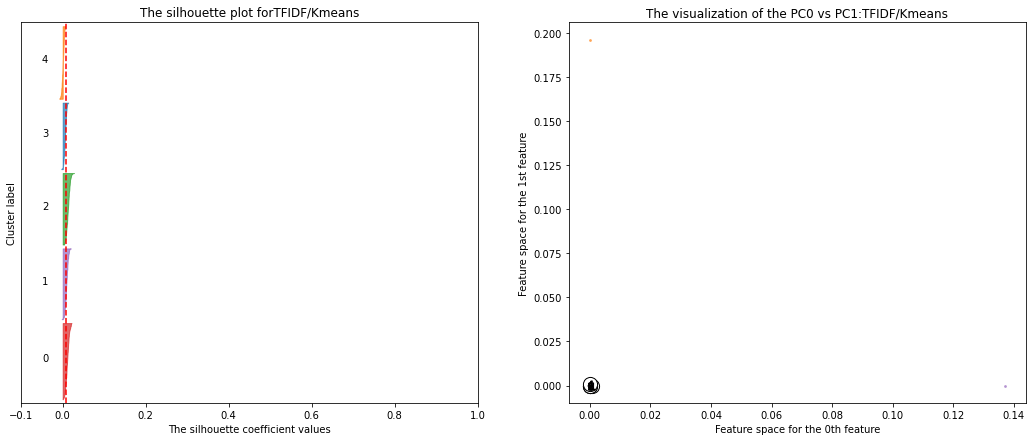

In [ ]:
silhouette_analysis(tfidf_train_data.toarray(), pred_labels,TFIDF_KMeans_cluster,'TFIDF/Kmeans')

In [ ]:
tfidf_train_data.shape

(1000, 12019)

In [ ]:
len(return_list_ofErrors(y_correspond_label))

42

# K-Means Clustering - BoW

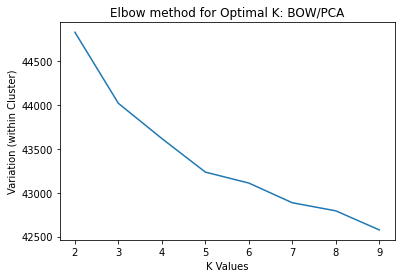

In [ ]:
elbow_for_k(X_train_bow_pca,': BOW/PCA')

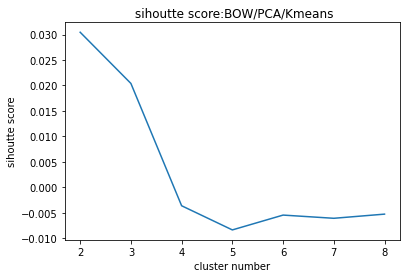

In [ ]:
sihoutte_for_k(X_train_bow_pca,' sihoutte score:BOW/PCA/Kmeans')

In [ ]:
k = 5
km = KMeans(n_clusters=k, init='k-means++',max_iter=200, n_init=10,random_state=42)
km.fit_predict(X_train_bow_pca)

array([0, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 4,
       0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
pred_labels = km.labels_
pred_labels.shape

(1000,)

In [ ]:
Bow_KMeans_cluster=returnBookToCluster(df1,pred_labels)
Bow_KMeans_cluster

bryant-stories  chesterton-thursday  ...  clusterNum        cluster_label
0               7                   12  ...           0            moby_dick
1               2                  181  ...           2  chesterton-thursday
2             189                    7  ...           4       bryant-stories
3               2                    0  ...           3      milton-paradise
4               0                    0  ...           1   shakespeare-hamlet

[5 rows x 7 columns]

### Visualizing the clusters

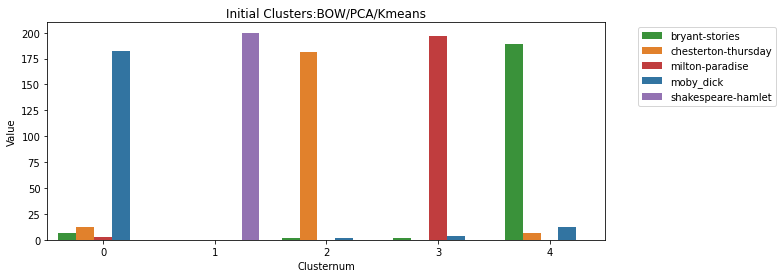

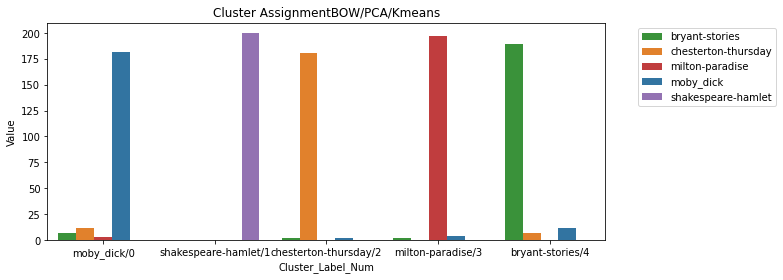

In [ ]:
plotInitialCluster(Bow_KMeans_cluster,'BOW/PCA/Kmeans')

### Predicted and actual label association

In [ ]:
y_correspond_label=return_cluster_y_emp(Bow_KMeans_cluster,pred_labels,df1)
y_correspond_label

cluster  ...                                            passage
0              moby_dick  ...  poet   -PRON- be really a poet who have become...
1    chesterton-thursday  ...  that when -PRON- break up rather hurriedly the...
2    chesterton-thursday  ...  as to send a lame man    -PRON- set off at a s...
3    chesterton-thursday  ...    gregory   upon the whole nature of poetry   ...
4    chesterton-thursday  ...  thread   -PRON- come nearer and near   the lam...
..                   ...  ...                                                ...
995      milton-paradise  ...  unexampled love   love no where to be find les...
996      milton-paradise  ...  then return at shut of evening flower   but   ...
997      milton-paradise  ...    to be deem a god   leap fondly into aetna fl...
998      milton-paradise  ...  -PRON- malice serve but to bring forth infinit...
999      milton-paradise  ...  the mouth of hell for ever   and seal up -PRON...

[1000 rows x 3 columns]

### Confusion Matrix

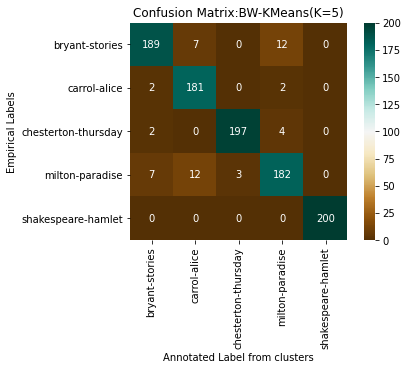

In [ ]:
 plot_confusion_matrix(y_correspond_label['cluster'],y_correspond_label['empirical cluster'],'BW-KMeans(K=5)')

### Kappa Score

In [ ]:
cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])

0.93625

### Silhouette analysis

The average silhouette_score is : -0.007005684325760566


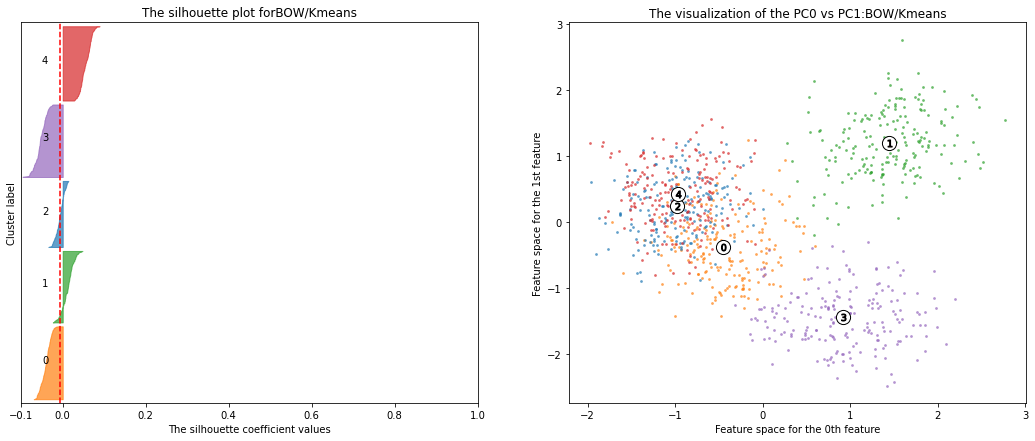

In [ ]:
silhouette_analysis(X_train_bow_pca, pred_labels,Bow_KMeans_cluster,'BOW/Kmeans')

### PCA Visualization

In [ ]:
pca.explained_variance_ratio_[0:4]

array([0.0168228 , 0.0141671 , 0.00805332, 0.00720148])

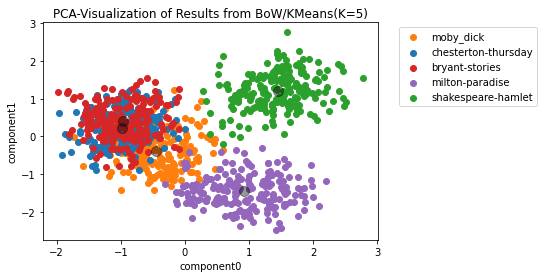

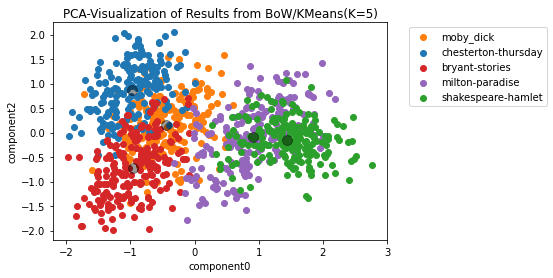

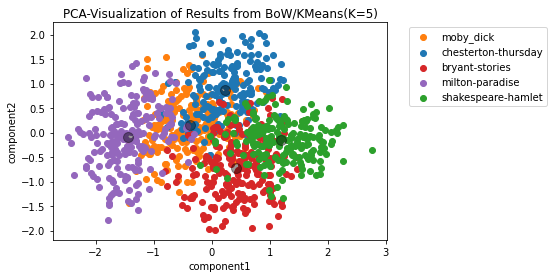

In [ ]:
tfidf_pca_visu=pd.DataFrame(X_train_bow_pca)
tfidf_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
plot_clusters_Kmeans(0,1,tfidf_pca_visu,'PCA-Visualization of Results from BoW/KMeans(K=5)',km)
plot_clusters_Kmeans(0,2,tfidf_pca_visu,'PCA-Visualization of Results from BoW/KMeans(K=5)',km)
plot_clusters_Kmeans(1,2,tfidf_pca_visu,'PCA-Visualization of Results from BoW/KMeans(K=5)',km)

### List of errors

In [ ]:
len(return_list_ofErrors(y_correspond_label))

51

# K-Means Clustering - Word2Vec

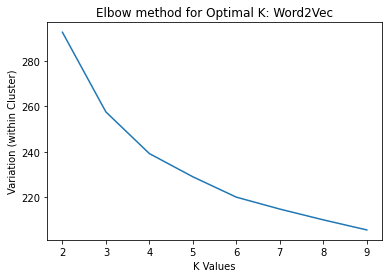

In [ ]:
elbow_for_k(x_word_2_vec,': Word2Vec')

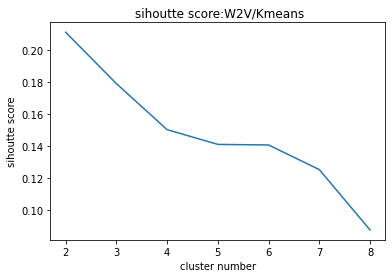

In [ ]:
sihoutte_for_k(x_word_2_vec,' sihoutte score:W2V/Kmeans')

In [ ]:
k = 5
km = KMeans(n_clusters=k, init='k-means++',max_iter=200, n_init=10,random_state=42)
km.fit_predict(x_word_2_vec)

array([3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 0, 2, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3,
       0, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 3, 0,
       0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 3, 3, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 3, 0, 2, 0, 0, 3, 3, 3, 3, 0, 3, 3, 2, 3, 3, 0, 0, 0, 0, 3, 0,
       0, 3, 0, 0, 0, 2, 0, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 3,
       0, 3, 3, 2, 0, 0, 0, 0, 2, 3, 0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 3, 3,
       0, 2, 0, 3, 0, 3, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2,
       3, 3, 2, 2, 1, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 4, 4, 2, 0,
       3, 2, 1, 3, 2, 3, 2, 2, 2, 0, 0, 2, 3, 2, 2, 2, 3, 3, 2, 4, 3, 3,
       2, 0, 3, 3, 2, 2, 2, 3, 4, 3, 3, 0, 2, 3, 3, 3, 0, 2, 0, 3, 2, 2,
       0, 2, 2, 3, 0, 2, 3, 3, 3, 2, 2, 2, 0, 0, 3, 0, 1, 2, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 2, 0, 2, 3, 3, 3, 2, 2, 3, 3,

In [ ]:
pred_labels = km.labels_
pred_labels.shape

(1000,)

In [ ]:
w2v_KMeans_cluster=returnBookToCluster(df1,pred_labels)
w2v_KMeans_cluster

bryant-stories  chesterton-thursday  ...  clusterNum        cluster_label
0              98                   77  ...           3       bryant-stories
1              83                  113  ...           0  chesterton-thursday
2              13                   10  ...           2            moby_dick
3               3                    0  ...           1      milton-paradise
4               3                    0  ...           4   shakespeare-hamlet

[5 rows x 7 columns]

### Visualizing the clusters

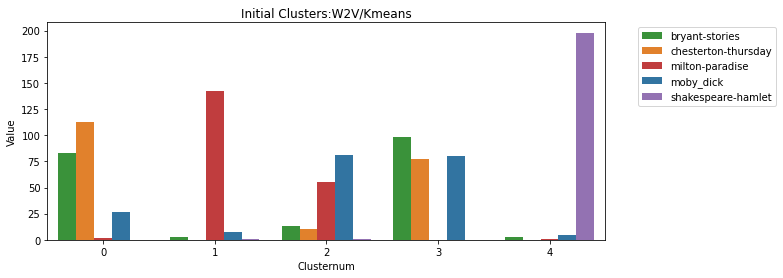

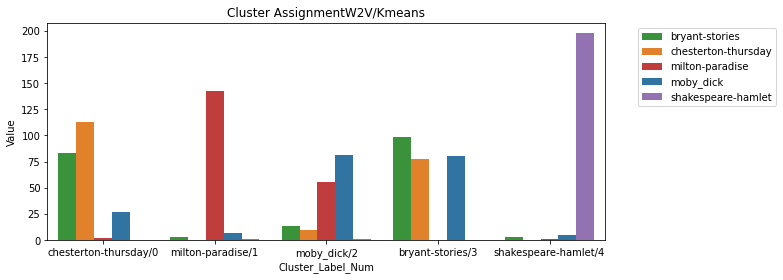

In [ ]:
plotInitialCluster(w2v_KMeans_cluster,'W2V/Kmeans')

### Predicted and actual label association

In [ ]:
y_correspond_label=return_cluster_y_emp(w2v_KMeans_cluster,pred_labels,df1) 

### Confusion Matrix

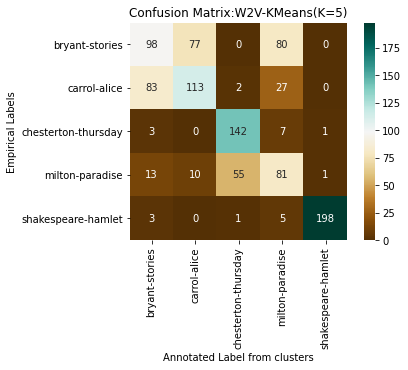

In [ ]:
 plot_confusion_matrix(y_correspond_label['cluster'],y_correspond_label['empirical cluster'],'W2V-KMeans(K=5)')

### Kappa Score

In [ ]:
cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])

0.54

### Silhouette analysis

The average silhouette_score is : 0.14106396


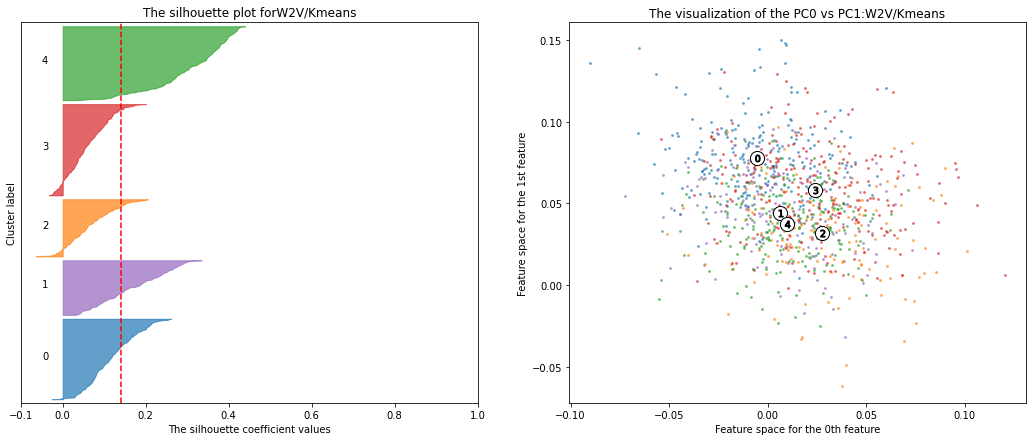

In [ ]:
silhouette_analysis(x_word_2_vec,pred_labels, w2v_KMeans_cluster,'W2V/Kmeans')


### PCA Visualization

In [ ]:
pca.explained_variance_ratio_[0:4]

array([0.0168228 , 0.0141671 , 0.00805332, 0.00720148])

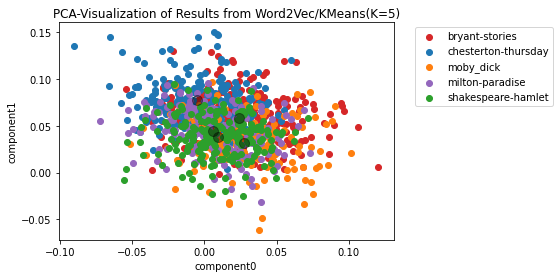

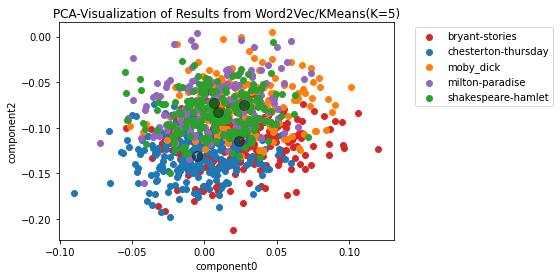

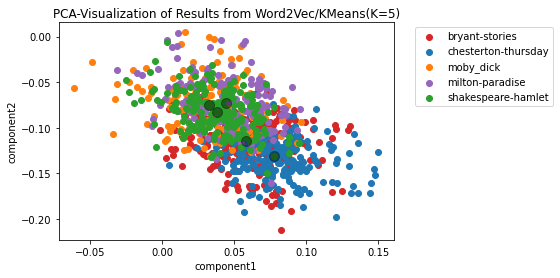

In [ ]:
tfidf_pca_visu=pd.DataFrame(x_word_2_vec)
tfidf_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
plot_clusters_Kmeans(0,1,tfidf_pca_visu,'PCA-Visualization of Results from Word2Vec/KMeans(K=5)',km)
plot_clusters_Kmeans(0,2,tfidf_pca_visu,'PCA-Visualization of Results from Word2Vec/KMeans(K=5)',km)
plot_clusters_Kmeans(1,2,tfidf_pca_visu,'PCA-Visualization of Results from Word2Vec/KMeans(K=5)',km)

### List of errors

In [ ]:
len(return_list_ofErrors(y_correspond_label))

368

### Using a Dendrogram to find the optimal numbers of Clusters

To get the number of clusters for hierarchical clustering, we make use of a concept called a **Dendrogram**

A Dendrogram is a type of tree diagram showing hierarchical relationships between different sets of data.

We make use of ward method which is a method that tries to minimize the variance within each cluster. We are minimizing the within-cluster variants. That is the variance within each cluster. 

# Hierachichal Clustering Using TFIDIF/PCA

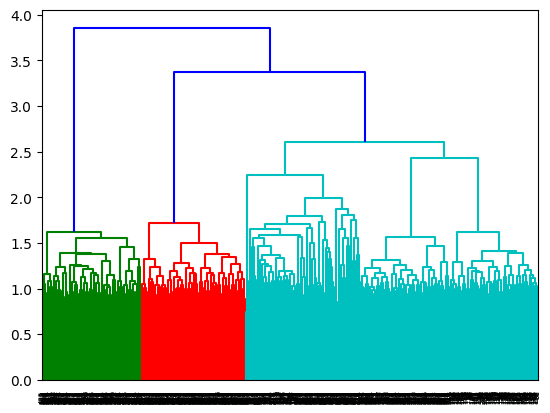

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(X_train_tfidf_pca,method = 'ward'))


### Truncated dendrogram for Better Visual Representation

The dendrogram can be hard to read when the original observation matrix from which the linkage is derived is large. We use truncation to condense the dendrogram. 

There are several modes to truncate the dendrogram. 
Here we use 'lastp' method : The last p non singleton clusters formed in the linkage are the only non-leaf nodes in the linkage. All the non singleton clusters are contracted into leaf nodes. 

In [ ]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage


In [ ]:
def trunc_dendrogram(x_training,methodName,distanceValue):
  from scipy.cluster.hierarchy import dendrogram, linkage

  Z = linkage(x_training, 'ward') 

  plt.title('Hierarchical Clustering Dendrogram (truncated):' +methodName)
  plt.xlabel('sample index')
  plt.ylabel('distance')
  dendrogram(
      Z,
      truncate_mode='lastp',  # show only the last p merged clusters
      p=30,  # show only the last p merged clusters
      leaf_rotation=90.,
      leaf_font_size=12.,
      show_contracted=True,  # to get a distribution impression in truncated branches
    ) 
  plt.axhline(y=distanceValue,color='black',linestyle='--')
  plt.show()

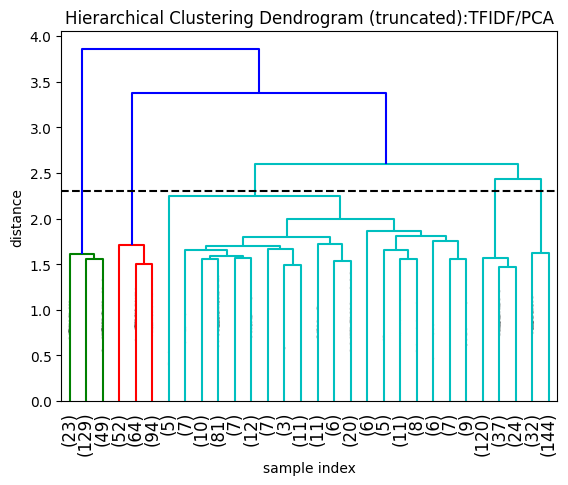

In [ ]:

trunc_dendrogram(X_train_tfidf_pca,'TFIDF/PCA',2.3)

### Case study for linkage and distance 
We compare the combinations of values among the linkage and distance parameters. 

In [ ]:
def linkage_distance(x_train,model_title):
  linkageList=[]
  cohenList=[]

  k=5
  for linkage in ('ward', 'average', 'complete', 'single'):
    for affinity in ('euclidean', 'manhattan','cosine'):
      if (linkage=='ward' and affinity in ['manhattan','cosine']):
        continue
      else:
        linkageList.append(linkage+'-'+affinity)
        Hclustering = AgglomerativeClustering(n_clusters=k, affinity=affinity,linkage=linkage)
        Hclustering.fit(x_train)
        Predicted_cluster = Hclustering.labels_            
        HC_cluster=returnBookToCluster(df1,Predicted_cluster)
        y_correspond_label=return_cluster_y_emp(HC_cluster,Predicted_cluster,df1)
        cohen=cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])
        cohenList.append(cohen)
        print(linkage, affinity,cohen)

            
  linkageArray=np.array(linkageList)
  cohenArray=np.array(cohenList)
  print(linkageList)

 
  plt.title('Linkage-Distance Accuracy:'+model_title)
  plt.xlabel('Parameter type')
  plt.ylabel('Cohen Score')
  plt.xticks(rotation=90)
  plt.plot(linkageArray,cohenArray*100, marker ='o', markerfacecolor='black')

  plt.show()



In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

ward euclidean 0.90875
average euclidean 0.0207344491631275
average manhattan 0.008491508491508482
average cosine 0.93375
complete euclidean 0.05874999999999997
complete manhattan 0.23375
complete cosine 0.28
single euclidean 0.017745563609097736
single manhattan 0.0032475643267549925
single cosine 0.001998501124156782
['ward-euclidean', 'average-euclidean', 'average-manhattan', 'average-cosine', 'complete-euclidean', 'complete-manhattan', 'complete-cosine', 'single-euclidean', 'single-manhattan', 'single-cosine']


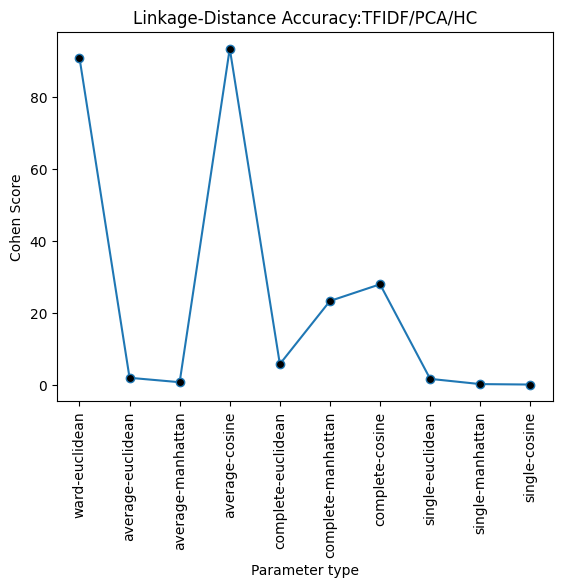

In [ ]:
linkage_distance(X_train_tfidf_pca,'TFIDF/PCA/HC')

### Buiding A model with the optimal parameters

As per our evaluation, we can see the optimal parameter for us is 'Average' and 'Cosine' for Linkage and affinity respectively. 

In [ ]:
k=5

Hclustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean',linkage='ward')
Hclustering.fit(X_train_tfidf_pca)
Predicted_cluster = Hclustering.labels_            
TFIDF_HC_cluster=returnBookToCluster(df1,Predicted_cluster)
y_correspond_label=return_cluster_y_emp(TFIDF_HC_cluster,Predicted_cluster,df1)
cohen=cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])
cohen

0.90875

In [ ]:
TFIDF_HC_cluster=returnBookToCluster(df1,Predicted_cluster)

In [ ]:
TFIDF_HC_cluster

bryant-stories  ...      cluster_label_num
0             196  ...       bryant-stories/0
1               1  ...  chesterton-thursday/1
2               0  ...      milton-paradise/2
3               3  ...            moby_dick/4
4               0  ...   shakespeare-hamlet/3

[5 rows x 8 columns]

In [ ]:
y_correspond_label=return_cluster_y_emp(TFIDF_HC_cluster,Predicted_cluster,df1)

In [ ]:
cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])

0.90875

In [ ]:
len(return_list_ofErrors(y_correspond_label))

73

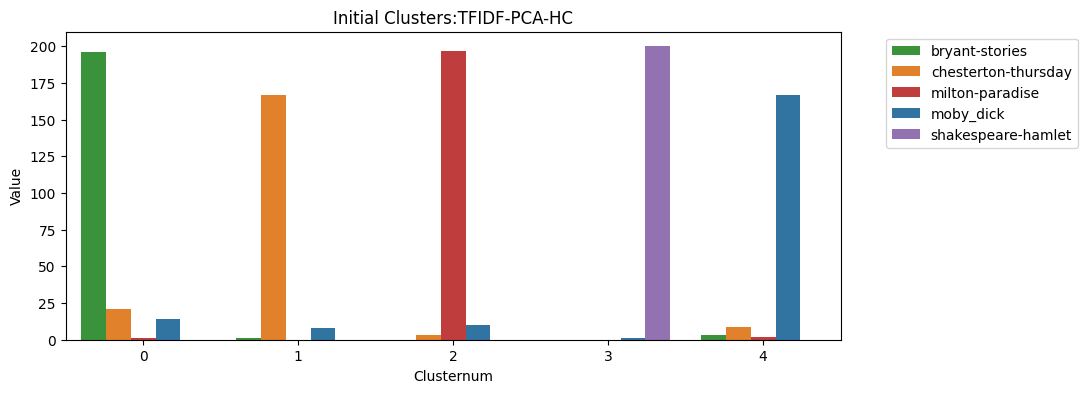

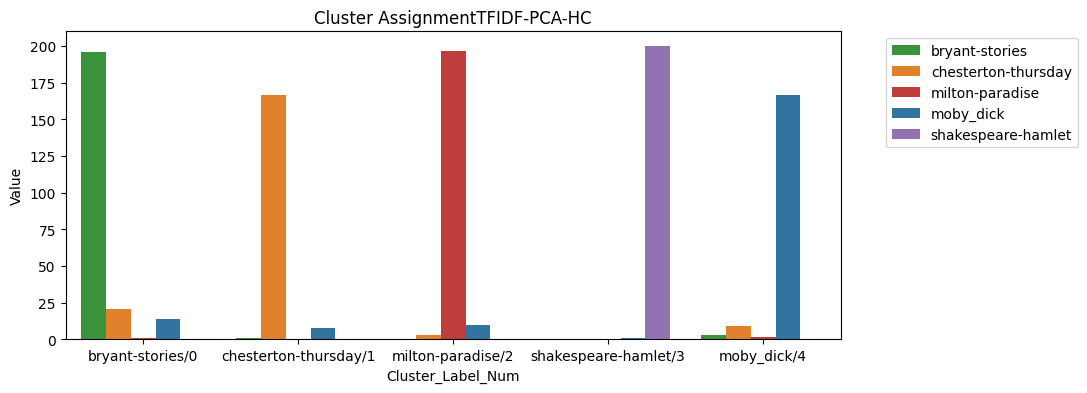

In [ ]:
plotInitialCluster(TFIDF_HC_cluster,'TFIDF-PCA-HC')

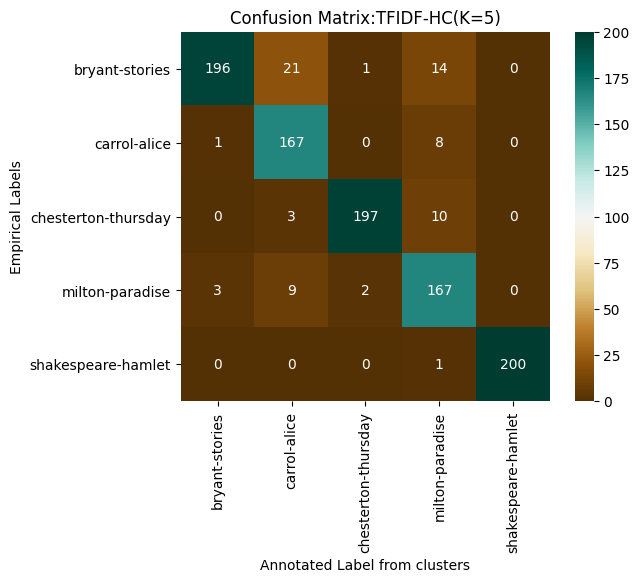

In [ ]:
 plot_confusion_matrix(y_correspond_label['cluster'],y_correspond_label['empirical cluster'],'TFIDF-HC(K=5)')

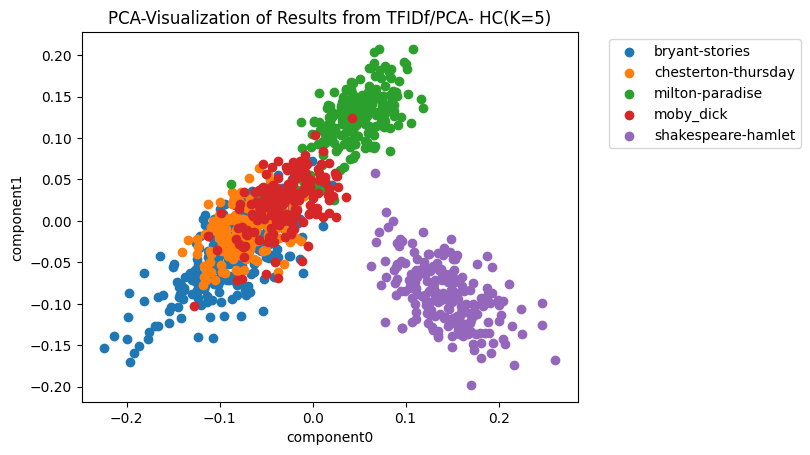

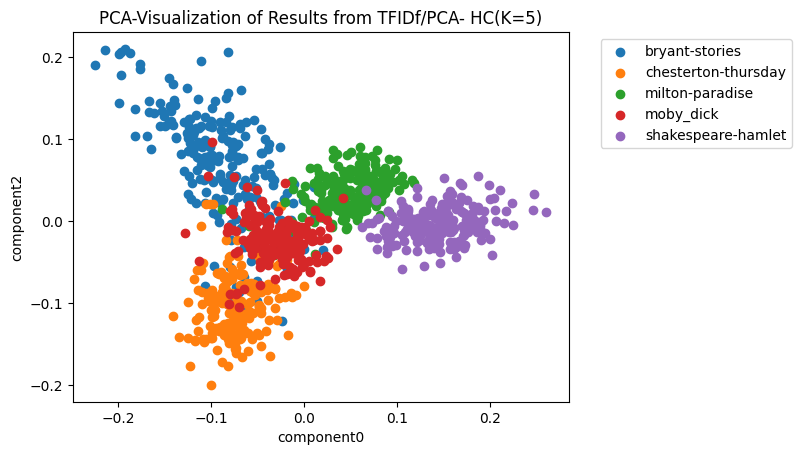

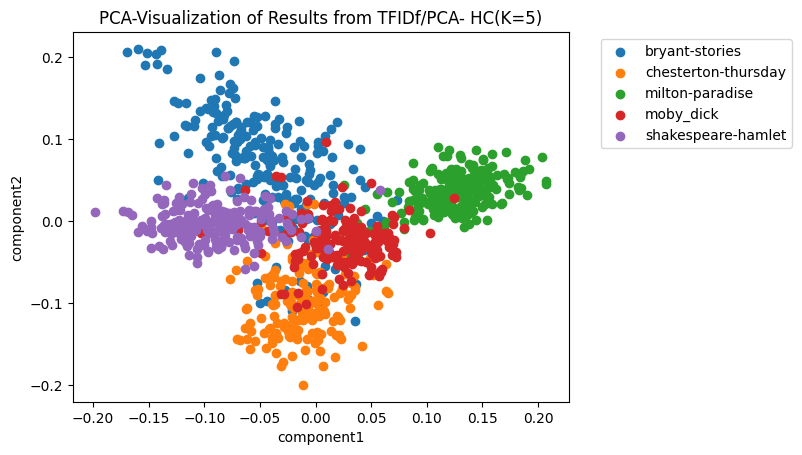

In [ ]:
tfidf_pca_visu=pd.DataFrame(X_train_tfidf_pca)
tfidf_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
plot_clusters(0,1,tfidf_pca_visu,'PCA-Visualization of Results from TFIDf/PCA- HC(K=5)')
plot_clusters(0,2,tfidf_pca_visu,'PCA-Visualization of Results from TFIDf/PCA- HC(K=5)')
plot_clusters(1,2,tfidf_pca_visu,'PCA-Visualization of Results from TFIDf/PCA- HC(K=5)')

# Hierarchichal Clustering Using BOW

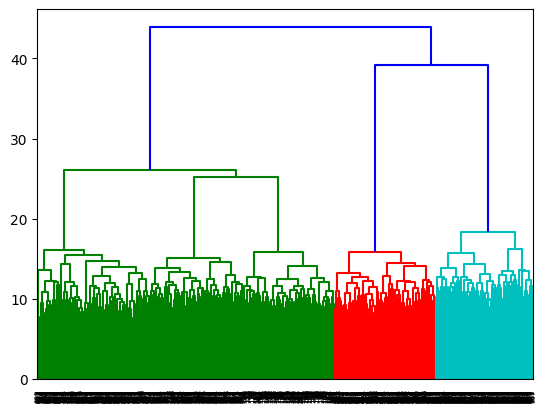

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(X_train_bow_pca,method = 'ward'))

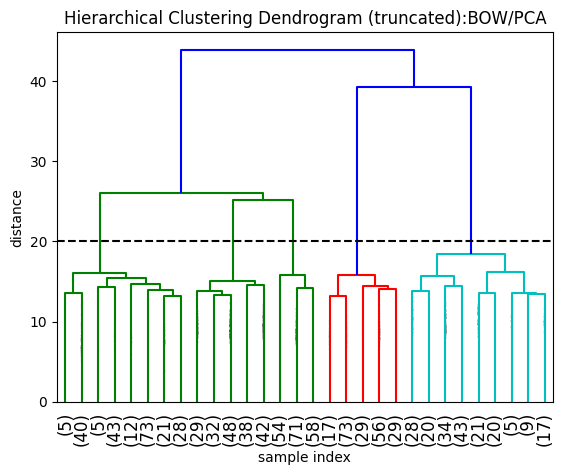

In [ ]:
trunc_dendrogram(X_train_bow_pca,'BOW/PCA',20)


### Case study for linkage and distance

ward euclidean 0.86
average euclidean 0.001998501124156782
average manhattan 0.001998501124156782
average cosine 0.8475
complete euclidean 0.07999999999999996
complete manhattan 0.16874999999999996
complete cosine 0.38375000000000004
single euclidean 0.001998501124156782
single manhattan 0.001998501124156782
single cosine 0.001998501124156893
['ward-euclidean', 'average-euclidean', 'average-manhattan', 'average-cosine', 'complete-euclidean', 'complete-manhattan', 'complete-cosine', 'single-euclidean', 'single-manhattan', 'single-cosine']


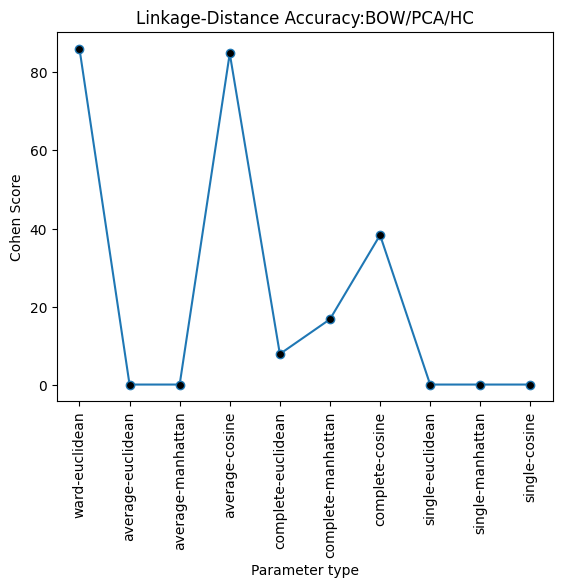

In [ ]:
linkage_distance(X_train_bow_pca,'BOW/PCA/HC')

### Building a model with optimal parameter

In [ ]:
k=5

Hclustering = AgglomerativeClustering(n_clusters=k, affinity='cosine',linkage='average')
Hclustering.fit(X_train_bow_pca)
Predicted_cluster_bow = Hclustering.labels_            
BOW_HC_cluster=returnBookToCluster(df1,Predicted_cluster_bow)
y_correspond_label=return_cluster_y_emp(BOW_HC_cluster,Predicted_cluster_bow,df1)
cohen=cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])


In [ ]:
cohen

0.8475

In [ ]:
len(return_list_ofErrors(y_correspond_label))

122

### Functions for Visualisation

In [ ]:
BOW_HC_cluster=returnBookToCluster(df1,Predicted_cluster)

In [ ]:
BOW_HC_cluster

bryant-stories  ...      cluster_label_num
0             196  ...       bryant-stories/0
1               1  ...  chesterton-thursday/1
2               0  ...      milton-paradise/2
3               3  ...            moby_dick/4
4               0  ...   shakespeare-hamlet/3

[5 rows x 8 columns]

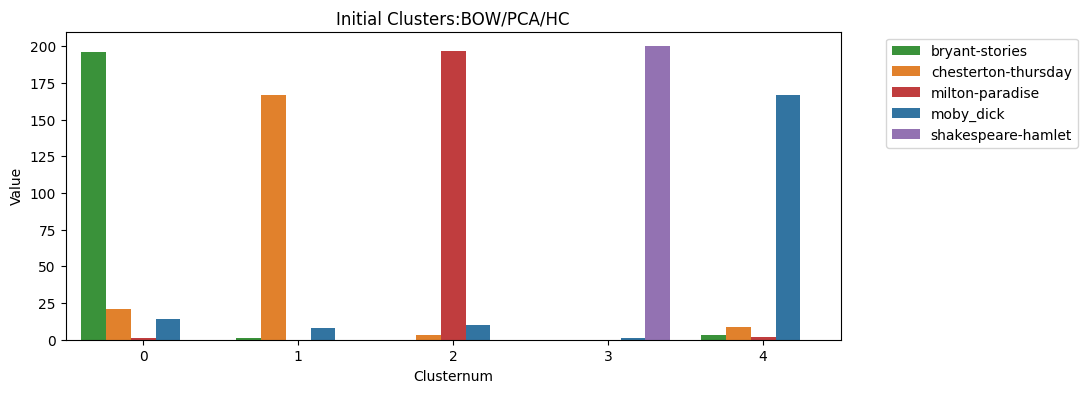

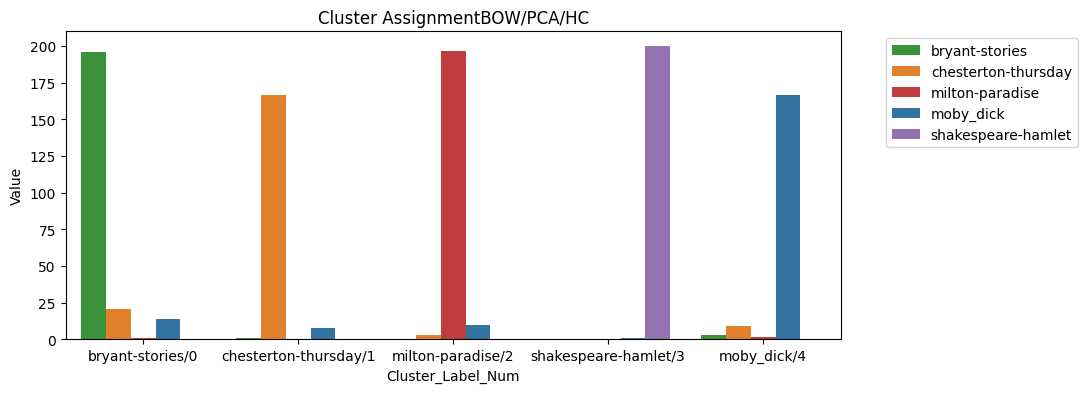

In [ ]:
plotInitialCluster(BOW_HC_cluster,'BOW/PCA/HC')

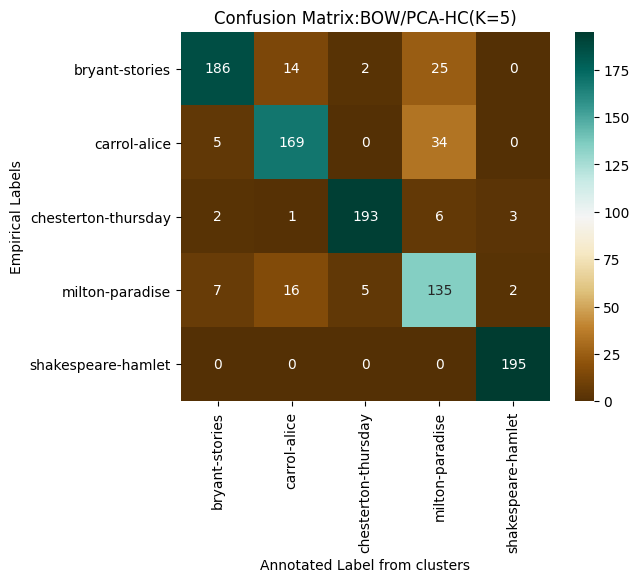

In [ ]:
 plot_confusion_matrix(y_correspond_label['cluster'],y_correspond_label['empirical cluster'],'BOW/PCA-HC(K=5)')

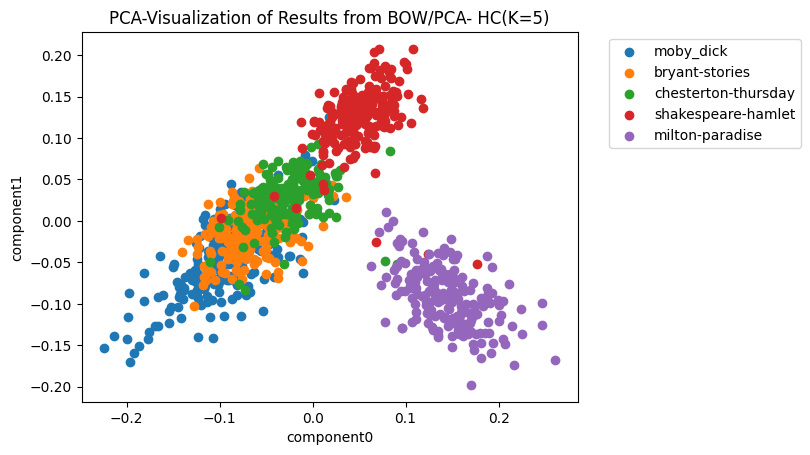

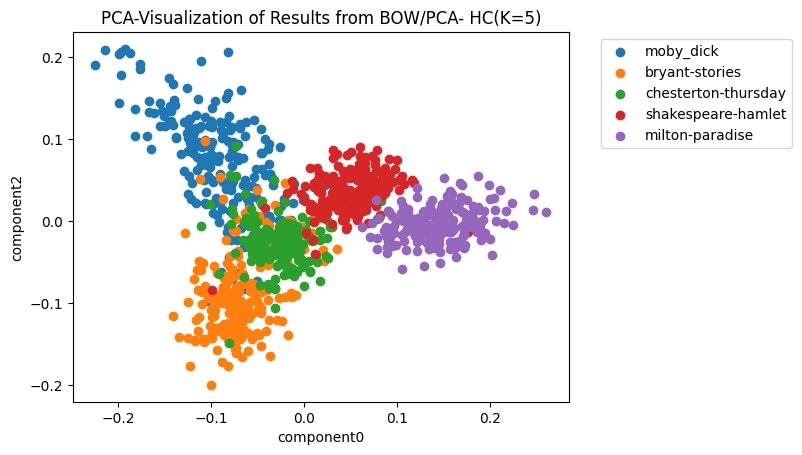

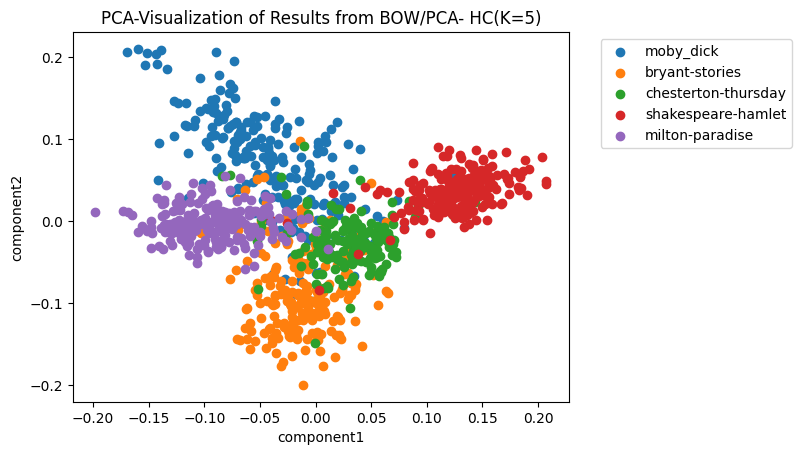

In [ ]:
tfidf_pca_visu=pd.DataFrame(X_train_tfidf_pca)
tfidf_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
plot_clusters(0,1,tfidf_pca_visu,'PCA-Visualization of Results from BOW/PCA- HC(K=5)')
plot_clusters(0,2,tfidf_pca_visu,'PCA-Visualization of Results from BOW/PCA- HC(K=5)')
plot_clusters(1,2,tfidf_pca_visu,'PCA-Visualization of Results from BOW/PCA- HC(K=5)')

# Hierarchichal Clustering Using Word2Vec

### Dendrogram

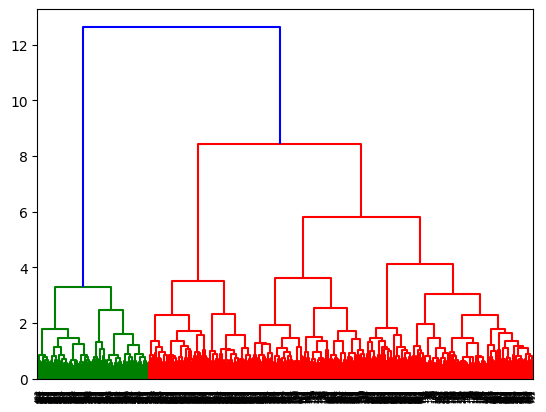

In [ ]:
dendrogram = sch.dendrogram(sch.linkage(x_word_2_vec,method = 'ward'))

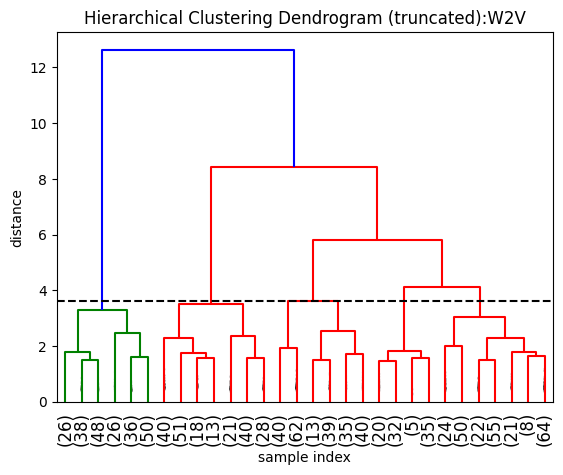

In [ ]:
trunc_dendrogram(x_word_2_vec,'W2V',3.6)

### Case study for linkage and distance

ward euclidean 0.6575
average euclidean 0.2503748125937032
average manhattan 0.019240379810094965
average cosine 0.24393901524618855
complete euclidean 0.44499999999999995
complete manhattan 0.4125
complete cosine 0.3137500000000001
single euclidean 0.001998501124156782
single manhattan 0.0032475643267549925
single cosine 0.001998501124156782
['ward-euclidean', 'average-euclidean', 'average-manhattan', 'average-cosine', 'complete-euclidean', 'complete-manhattan', 'complete-cosine', 'single-euclidean', 'single-manhattan', 'single-cosine']


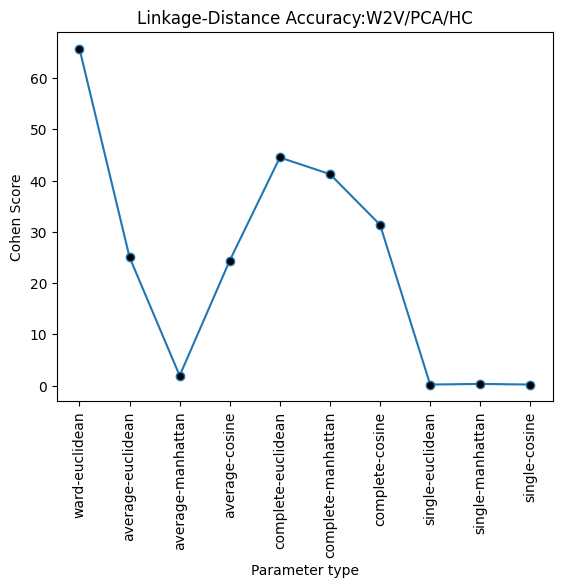

In [ ]:
linkage_distance(x_word_2_vec,'W2V/PCA/HC') 

### Buiding a model with optimal parameters

In [ ]:
k=5

Hclustering = AgglomerativeClustering(n_clusters=k, affinity='euclidean',linkage='ward')
Hclustering.fit(x_word_2_vec)
Predicted_cluster = Hclustering.labels_            
W2V_HC_cluster=returnBookToCluster(df1,Predicted_cluster)
y_correspond_label=return_cluster_y_emp(W2V_HC_cluster,Predicted_cluster,df1)
cohen=cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])
cohen

0.6575

In [ ]:
len(return_list_ofErrors(y_correspond_label))

274

### Functions for Visualisation

In [ ]:
W2V_HC_cluster=returnBookToCluster(df1,Predicted_cluster)

In [ ]:
W2V_HC_cluster

bryant-stories  ...      cluster_label_num
0              14  ...            moby_dick/0
1              89  ...  chesterton-thursday/3
2               4  ...      milton-paradise/2
3              89  ...       bryant-stories/4
4               4  ...   shakespeare-hamlet/1

[5 rows x 8 columns]

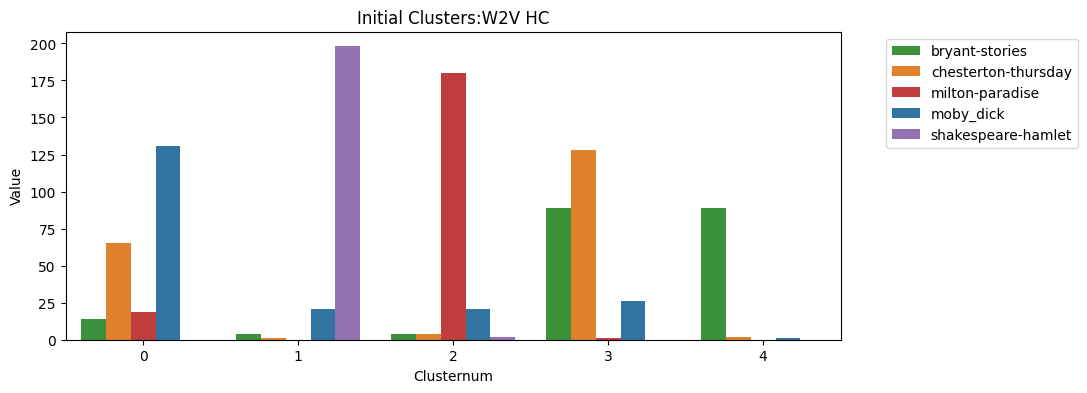

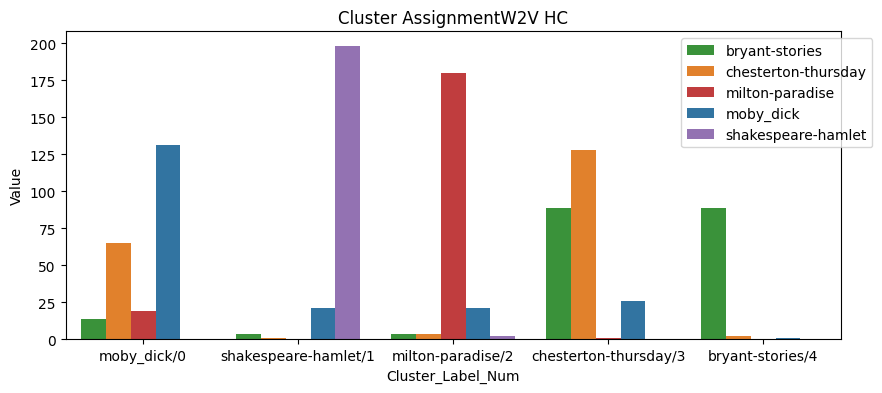

In [ ]:
plotInitialCluster(W2V_HC_cluster,'W2V HC')

In [ ]:
y_correspond_label=return_cluster_y_emp(W2V_HC_cluster,Predicted_cluster,df1[['bookName','passage']])

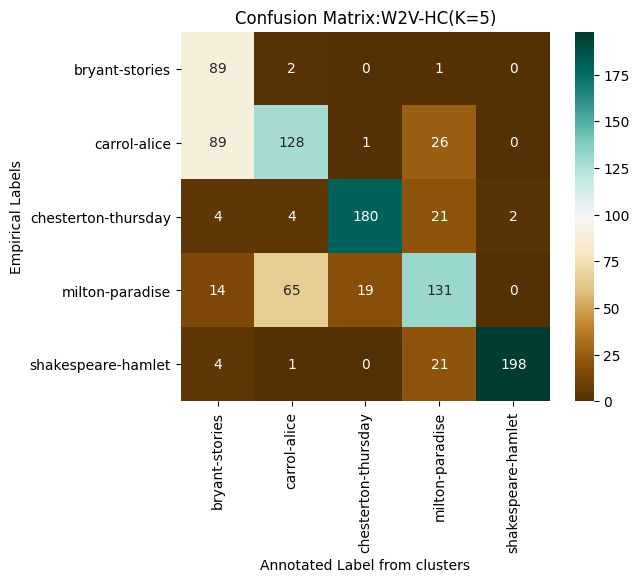

In [ ]:
plot_confusion_matrix(y_correspond_label['cluster'],y_correspond_label['empirical cluster'],'W2V-HC(K=5)')

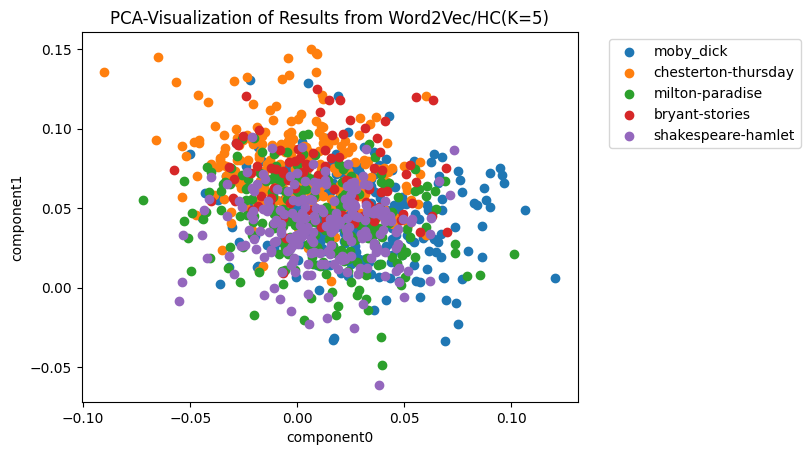

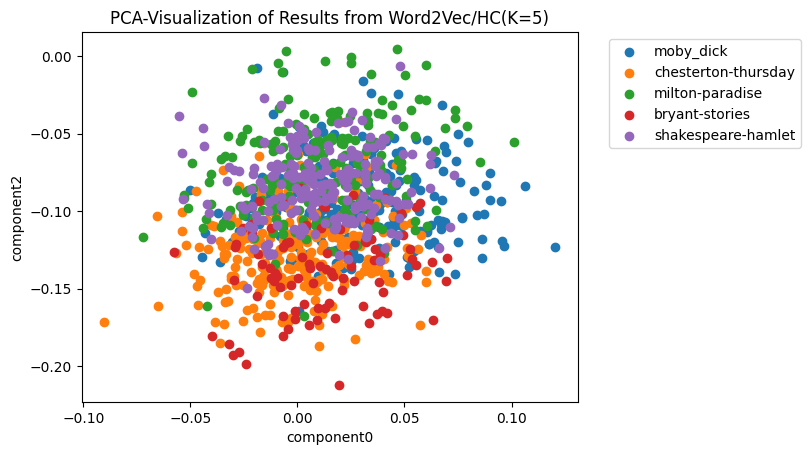

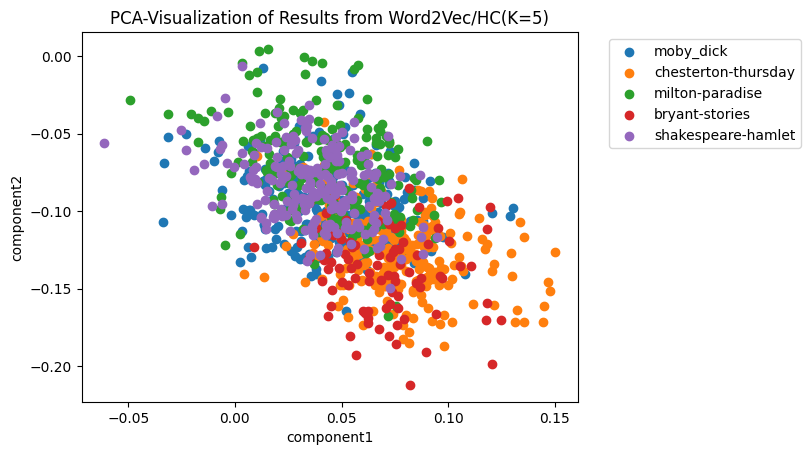

In [ ]:
Word2vec_pca_visu=pd.DataFrame(x_word_2_vec)
Word2vec_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
plot_clusters(0,1,Word2vec_pca_visu,'PCA-Visualization of Results from Word2Vec/HC(K=5)')
plot_clusters(0,2,Word2vec_pca_visu,'PCA-Visualization of Results from Word2Vec/HC(K=5)')
plot_clusters(1,2,Word2vec_pca_visu,'PCA-Visualization of Results from Word2Vec/HC(K=5)')

# GMM/EM with TFIDF 

In [ ]:
def sihoutte_for_kEM(x_train, methodName):
  num_clusters = list (range(2,9))
  sihouttescore=[]
  for n_clusters in num_clusters: 
      gm=GaussianMixture(n_components=n_clusters,random_state=42,n_init=10)
      preds = gm.fit_predict(x_train) 
      sihouttescore.append(silhouette_score(x_train, preds))
  plt.plot(num_clusters,sihouttescore)
  plt.xlabel('cluster number')
  plt.ylabel('sihoutte score')
  plt.title(methodName)

In [ ]:
def return_AIC_BIC(x_train,titlevalue):
  num_clusters = list (range(2,9))
  bic_score=[]
  aic_score=[]
  for n_clusters in num_clusters: 
      gm=GaussianMixture(n_components=n_clusters,random_state=42,n_init=10)
      preds = gm.fit(x_train) 
      bic_score.append(gm.bic(x_train))
      aic_score.append(gm.aic(x_train))
  plt.plot(num_clusters,bic_score,label='BIC')
  plt.plot(num_clusters,aic_score,label='AIC')
  plt.legend()
  plt.title(titlevalue)

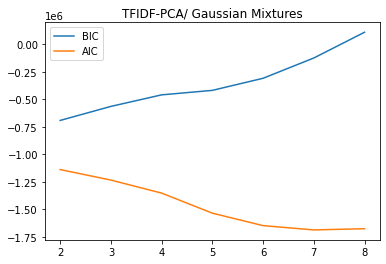

In [ ]:
return_AIC_BIC(X_train_tfidf_pca,'TFIDF-PCA/ Gaussian Mixtures')

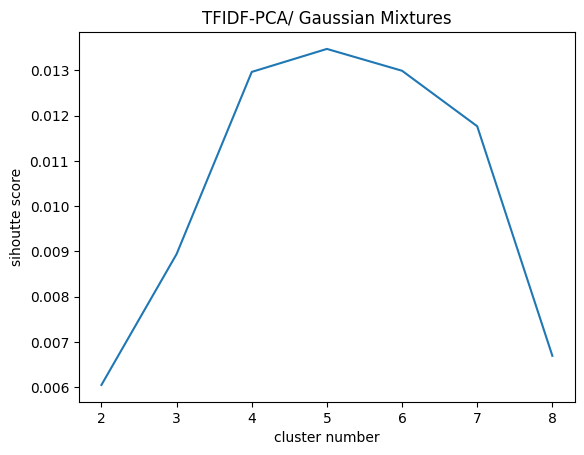

In [ ]:
sihoutte_for_kEM(X_train_tfidf_pca,'TFIDF-PCA/ Gaussian Mixtures')

In [ ]:

gm=GaussianMixture(n_components=5,random_state=42,n_init=10)
gm.fit(X_train_tfidf_pca)
y_cluster_tfidf_pcagm=gm.predict(X_train_tfidf_pca)

### Results and Evaluation 

### Assigning the cluster label from matching onto the previous label 

In [ ]:
TFIDF_EM_cluster=returnBookToCluster(df1,y_cluster_tfidf_pcagm)

In [ ]:
TFIDF_EM_cluster

bryant-stories  ...      cluster_label_num
0               7  ...            moby_dick/4
1               1  ...  chesterton-thursday/0
2             190  ...       bryant-stories/3
3               2  ...      milton-paradise/2
4               0  ...   shakespeare-hamlet/1

[5 rows x 8 columns]

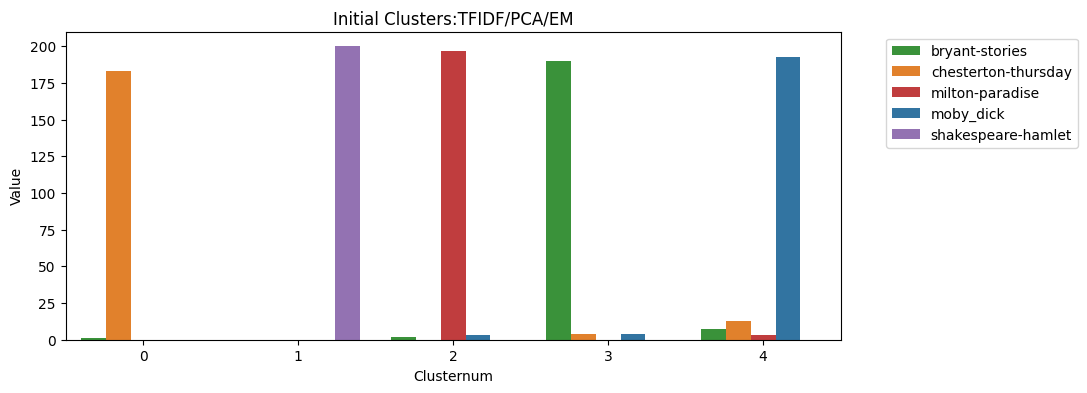

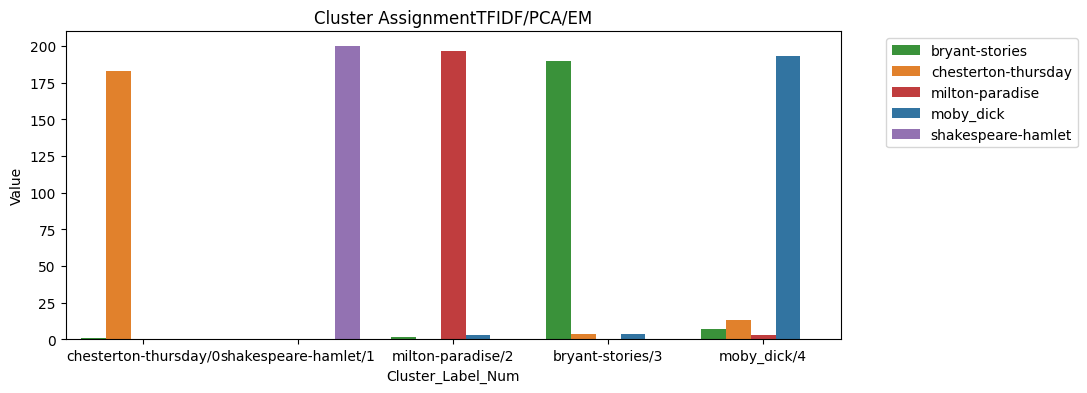

In [ ]:
plotInitialCluster(TFIDF_EM_cluster,'TFIDF/PCA/EM')

In [ ]:
y_correspond_label=return_cluster_y_emp(TFIDF_EM_cluster,y_cluster_tfidf_pcagm,df1[['bookName','passage']])

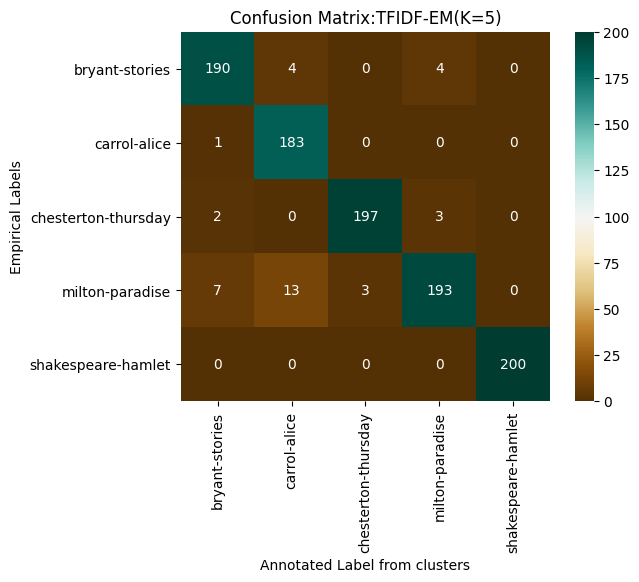

In [ ]:
 plot_confusion_matrix(y_correspond_label['cluster'],y_correspond_label['empirical cluster'],'TFIDF-EM(K=5)')

 ### Kappa Score 

In [ ]:
cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])

0.95375

Variance ratio of the PCA re organized from highest to lowest.
From 300 different components, the first component has 1.7% of the total weight and second component has 1.6% of the total weight .
Although these weights are not very high, these clusters play a more important role than the rest of the other cluster. 

In [ ]:
pca.explained_variance_ratio_[0:4]

array([0.0168228 , 0.0141671 , 0.00805332, 0.00720148])

### PCA Visualization of the clusters 
Note that there are 300 components but we only look at the top 3. 

In [ ]:
tfidf_pca_visu=pd.DataFrame(X_train_tfidf_pca)
tfidf_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
sorter=['chesterton-thursday', 'moby_dick', 'shakespeare-hamlet','bryant-stories', 'milton-paradise']
sorterIndex = dict(zip(sorter, range(len(sorter))))
tfidf_pca_visu['cluster_Rank'] = tfidf_pca_visu['cluster'].map(sorterIndex) 
tfidf_pca_visu.sort_values(['cluster_Rank'], inplace = True)
tfidf_pca_visu.drop('cluster_Rank', 1, inplace = True)

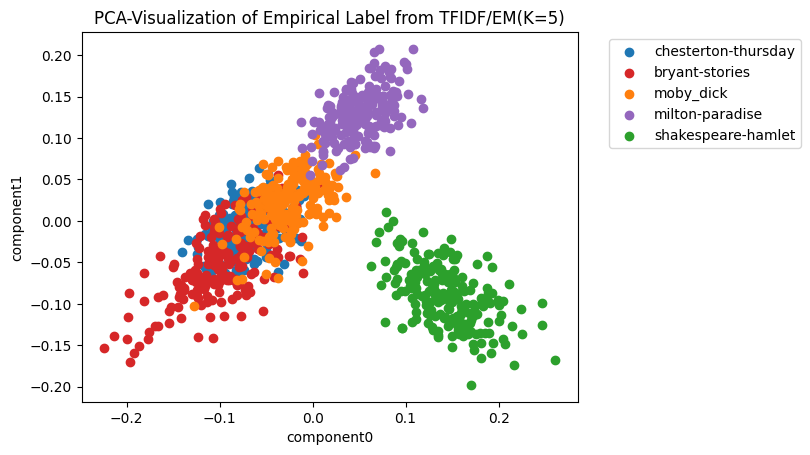

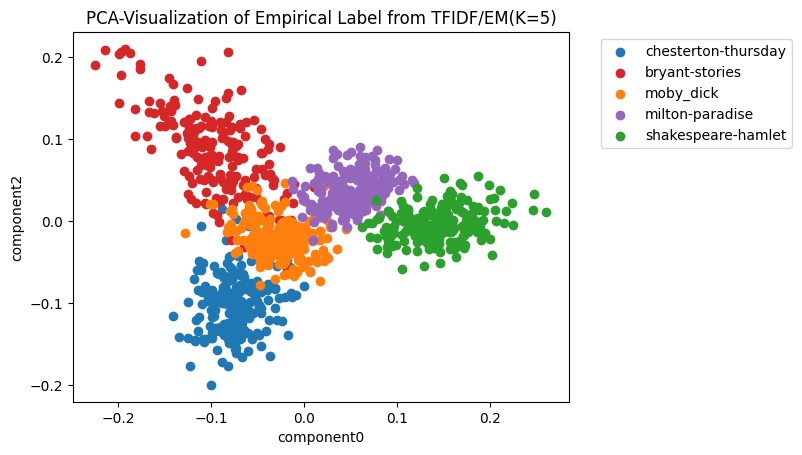

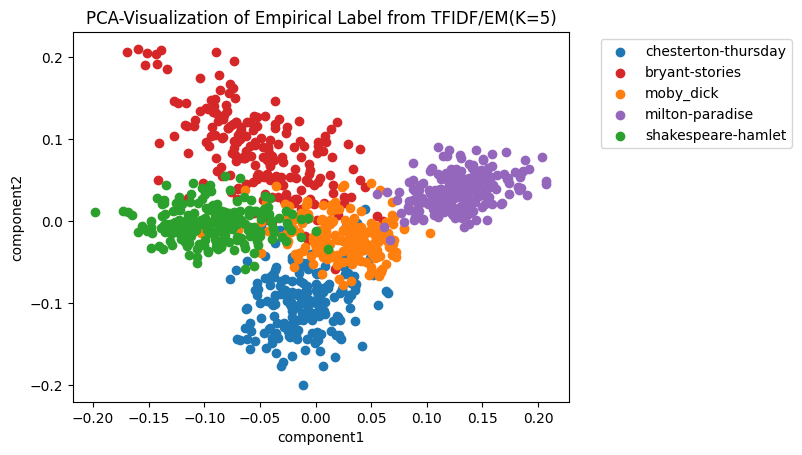

In [ ]:
plot_empirical_clusters(0,1,tfidf_pca_visu,'PCA-Visualization of Empirical Label from TFIDF/EM(K=5)')
plot_empirical_clusters(0,2,tfidf_pca_visu,'PCA-Visualization of Empirical Label from TFIDF/EM(K=5)')
plot_empirical_clusters(1,2,tfidf_pca_visu,'PCA-Visualization of Empirical Label from TFIDF/EM(K=5)')

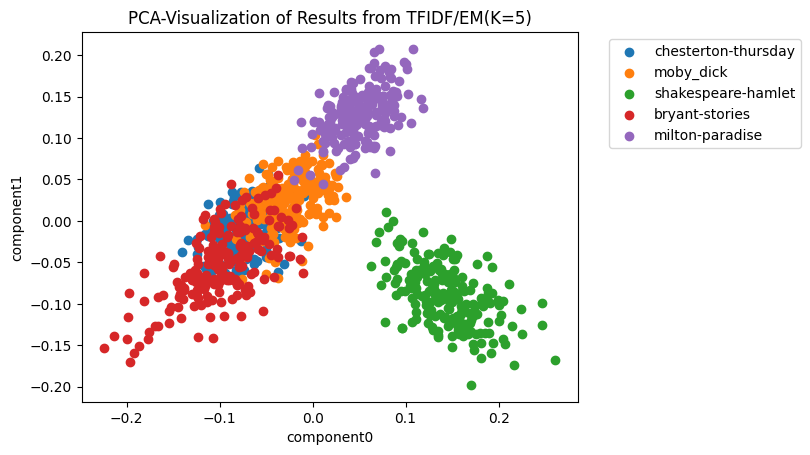

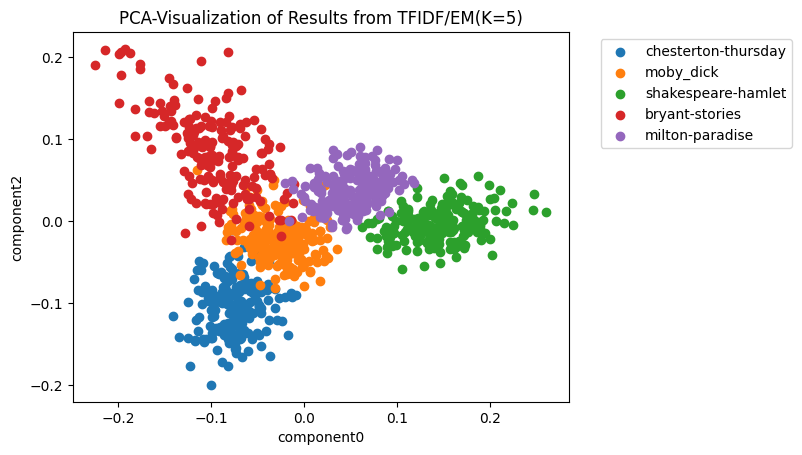

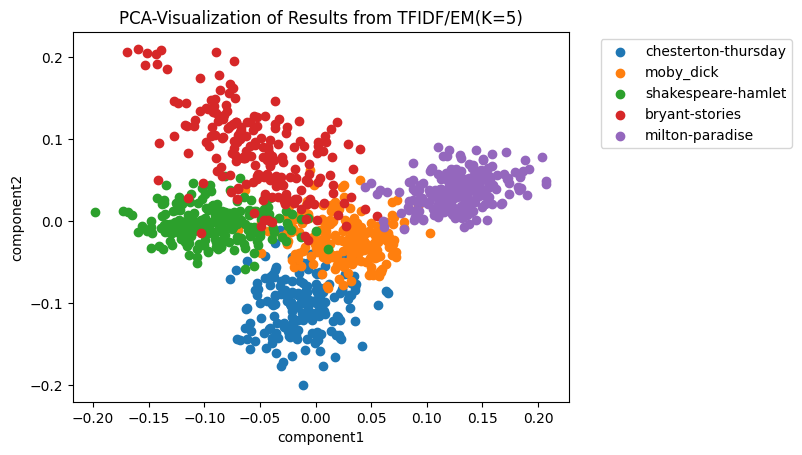

In [ ]:

plot_clusters(0,1,tfidf_pca_visu,'PCA-Visualization of Results from TFIDF/EM(K=5)')
plot_clusters(0,2,tfidf_pca_visu,'PCA-Visualization of Results from TFIDF/EM(K=5)')
plot_clusters(1,2,tfidf_pca_visu,'PCA-Visualization of Results from TFIDF/EM(K=5)')

In [ ]:
len(return_list_ofErrors(y_correspond_label))

37

# GMM/EM with BoW

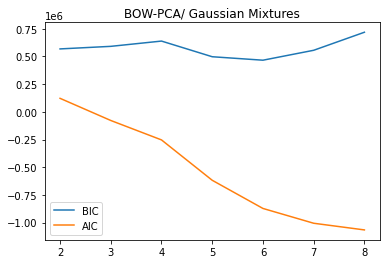

In [ ]:
return_AIC_BIC(X_train_bow_pca,'BOW-PCA/ Gaussian Mixtures')

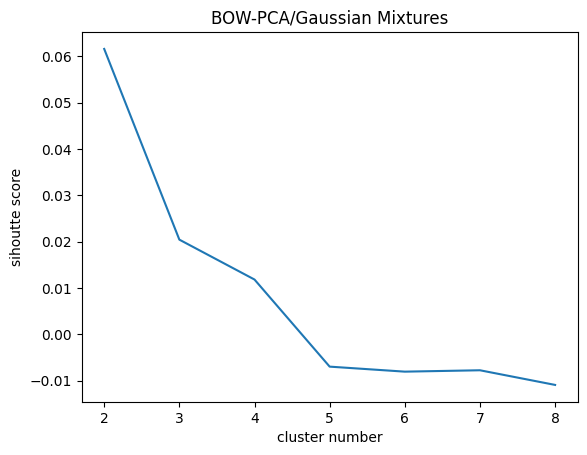

In [ ]:
sihoutte_for_kEM(X_train_bow_pca,'BOW-PCA/Gaussian Mixtures')


In [ ]:
gm=GaussianMixture(n_components=5,random_state=42,n_init=10)
gm.fit(X_train_bow_pca)
y_cluster_bow_pcagm=gm.predict(X_train_bow_pca)

In [ ]:
bow_EM_cluster=returnBookToCluster(df1,y_cluster_bow_pcagm)

In [ ]:
bow_EM_cluster

bryant-stories  chesterton-thursday  ...  clusterNum        cluster_label
0               7                   12  ...           0            moby_dick
1               2                  181  ...           2  chesterton-thursday
2             189                    7  ...           4       bryant-stories
3               2                    0  ...           3      milton-paradise
4               0                    0  ...           1   shakespeare-hamlet

[5 rows x 7 columns]

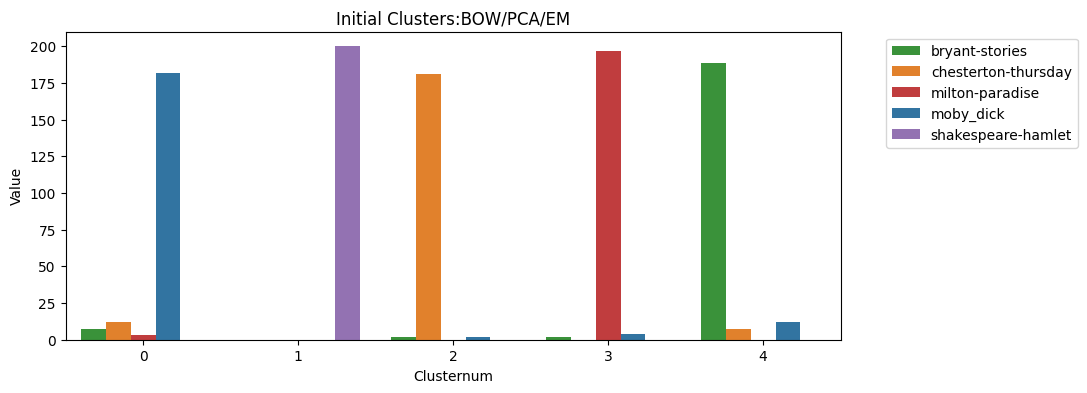

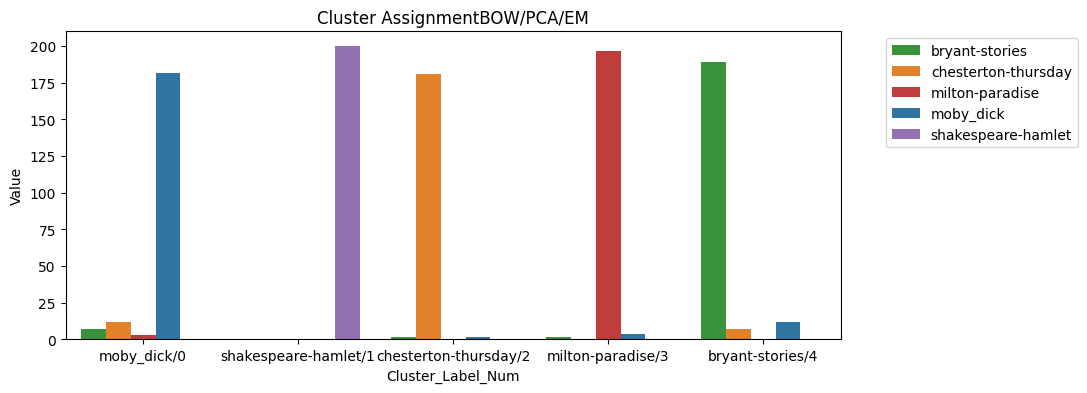

In [ ]:
 plotInitialCluster(bow_EM_cluster,'BOW/PCA/EM')

In [ ]:
 y_correspond_label=return_cluster_y_emp(bow_EM_cluster,y_cluster_bow_pcagm,df1[['bookName','passage']])

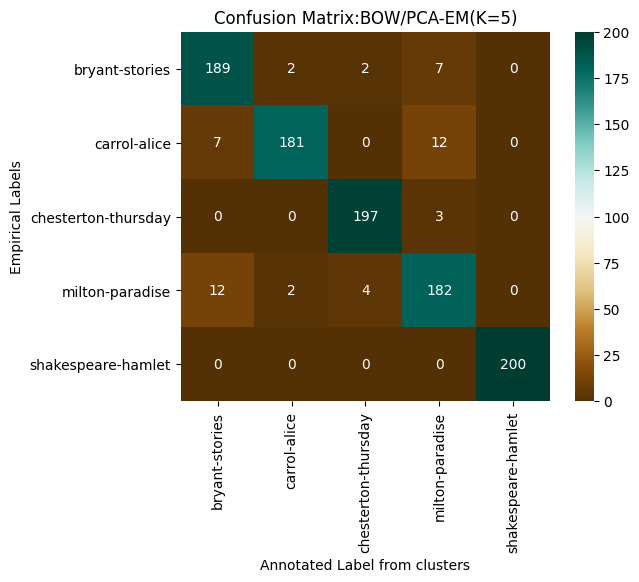

In [ ]:
 plot_confusion_matrix(y_correspond_label['empirical cluster'],y_correspond_label['cluster'],'BOW/PCA-EM(K=5)')

In [ ]:
 cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])

0.93625

In [ ]:
bow_pca_visu=pd.DataFrame(X_train_bow_pca)
bow_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
sorter=['chesterton-thursday', 'moby_dick', 'shakespeare-hamlet','bryant-stories', 'milton-paradise']
sorterIndex = dict(zip(sorter, range(len(sorter))))
bow_pca_visu['cluster_Rank'] = bow_pca_visu['cluster'].map(sorterIndex) 
bow_pca_visu.sort_values(['cluster_Rank'], inplace = True)
bow_pca_visu.drop('cluster_Rank', 1, inplace = True)

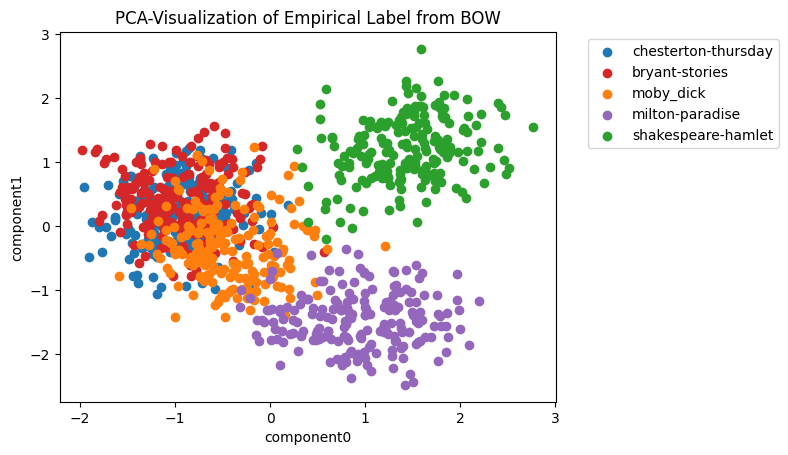

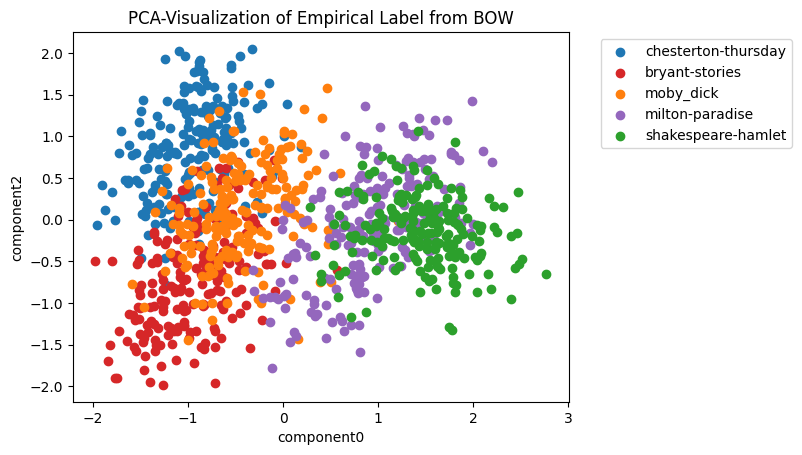

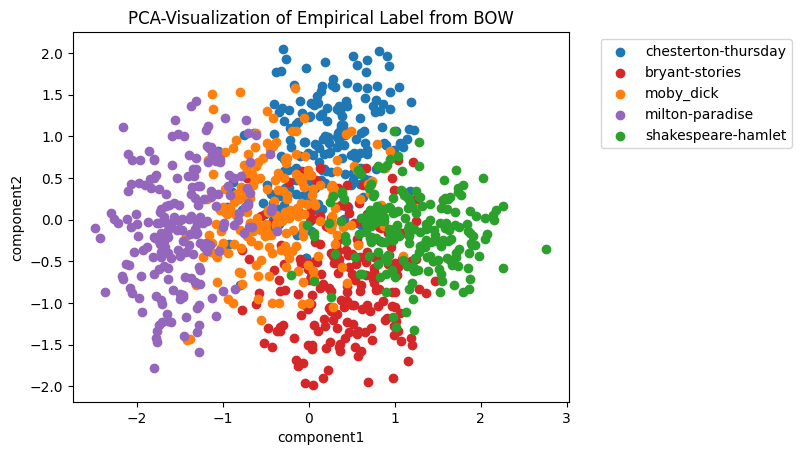

In [ ]:

plot_empirical_clusters(0,1,bow_pca_visu,'PCA-Visualization of Empirical Label from BOW')
plot_empirical_clusters(0,2,bow_pca_visu,'PCA-Visualization of Empirical Label from BOW')
plot_empirical_clusters(1,2,bow_pca_visu,'PCA-Visualization of Empirical Label from BOW')

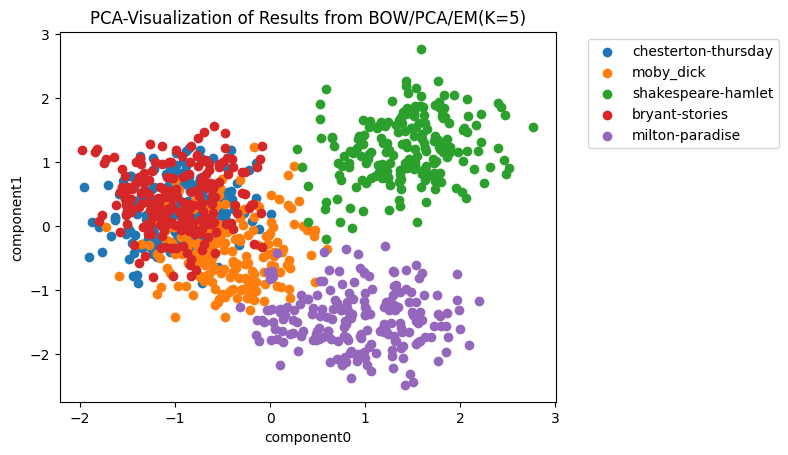

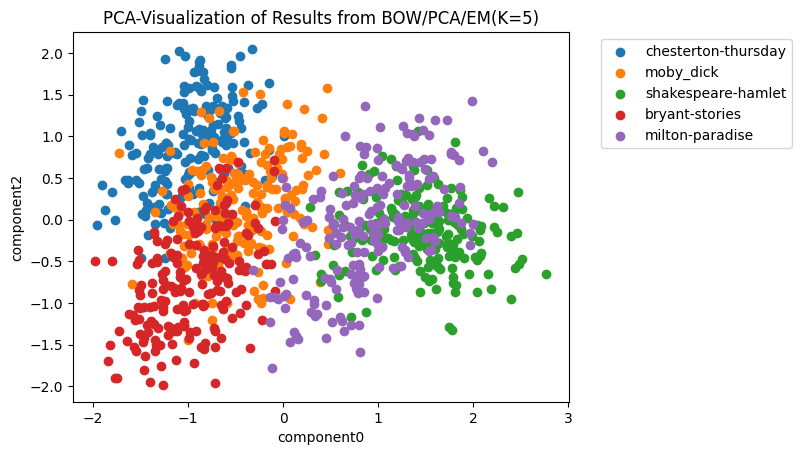

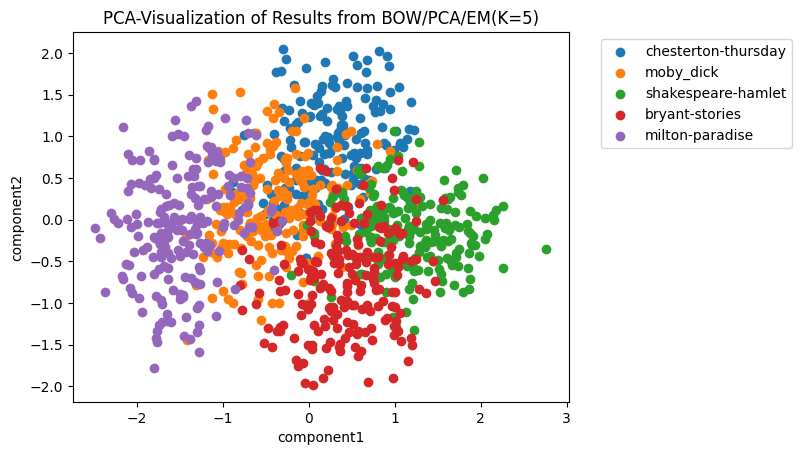

In [ ]:

bow_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
plot_clusters(0,1,bow_pca_visu,'PCA-Visualization of Results from BOW/PCA/EM(K=5)')
plot_clusters(0,2,bow_pca_visu,'PCA-Visualization of Results from BOW/PCA/EM(K=5)')
plot_clusters(1,2,bow_pca_visu,'PCA-Visualization of Results from BOW/PCA/EM(K=5)')

In [ ]:
len(return_list_ofErrors(y_correspond_label))

51

# GMM/EM with Word2Vec

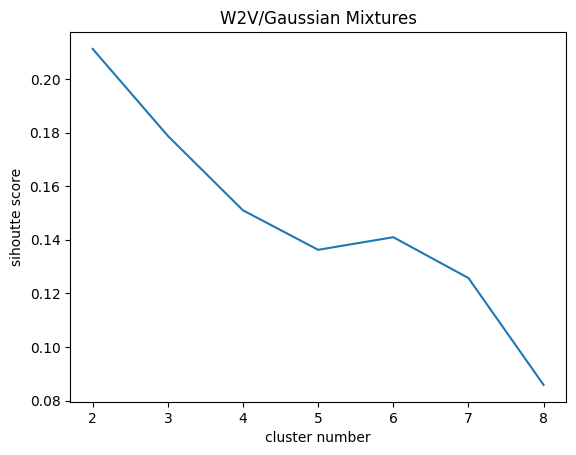

In [ ]:
sihoutte_for_kEM(x_word_2_vec,'W2V/Gaussian Mixtures')


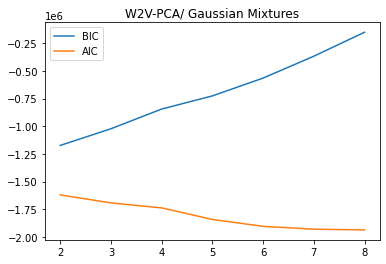

In [ ]:
return_AIC_BIC(x_word_2_vec,'W2V/ Gaussian Mixtures')

In [ ]:
gm=GaussianMixture(n_components=5,random_state=42,n_init=10)
gm.fit(x_word_2_vec)
y_cluster_W2V_gm=gm.predict(x_word_2_vec)

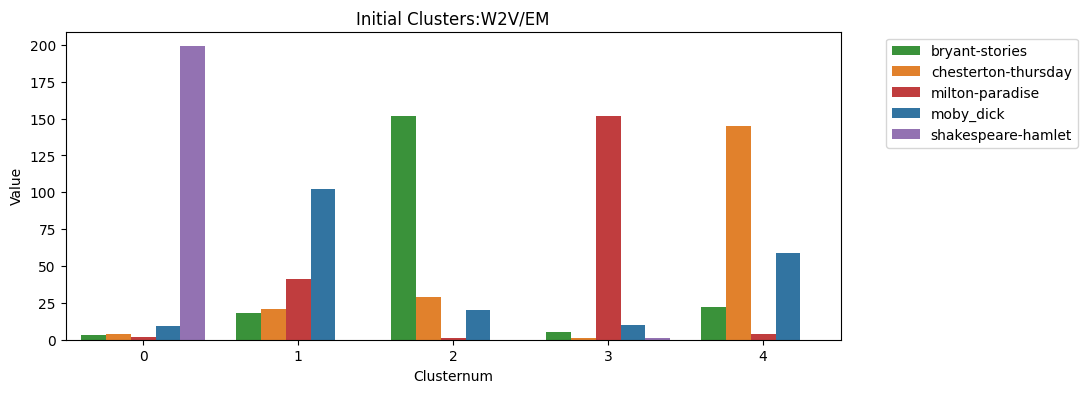

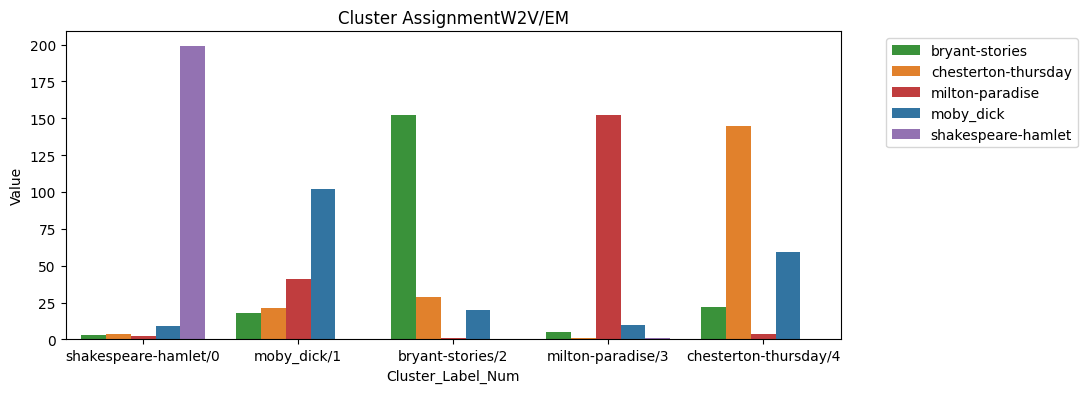

In [ ]:
W2V_EM_cluster=returnBookToCluster(df1,y_cluster_W2V_gm)
plotInitialCluster(W2V_EM_cluster,'W2V/EM')

In [ ]:
W2V_EM_cluster['clusterNum']=W2V_EM_cluster['clusterNum'].astype(int) 
y_correspond_label=return_cluster_y_emp(W2V_EM_cluster,y_cluster_W2V_gm,df1[['bookName','passage']])

In [ ]:
W2V_EM_cluster

bryant-stories  ...      cluster_label_num
0              22  ...  chesterton-thursday/4
1              18  ...            moby_dick/1
2             152  ...       bryant-stories/2
3               3  ...   shakespeare-hamlet/0
4               5  ...      milton-paradise/3

[5 rows x 8 columns]

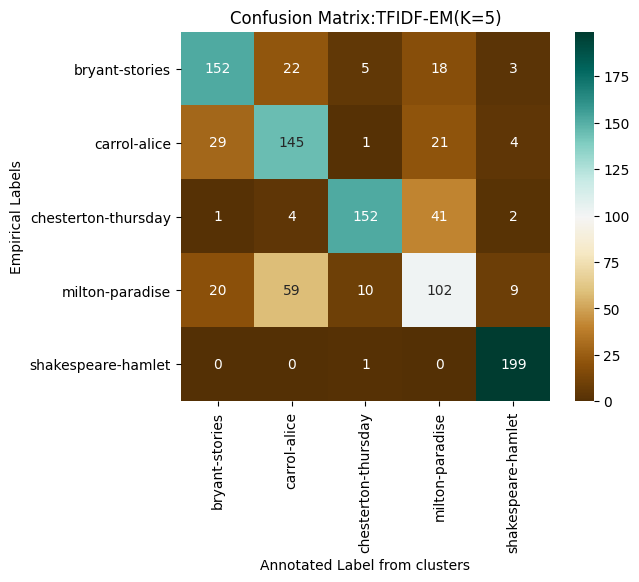

In [ ]:
 plot_confusion_matrix(y_correspond_label['empirical cluster'],y_correspond_label['cluster'],'TFIDF-EM(K=5)')

In [ ]:
 cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])

0.6875

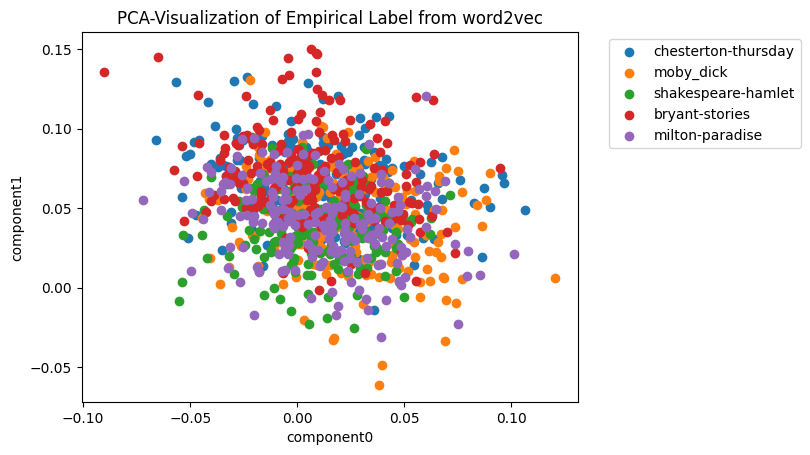

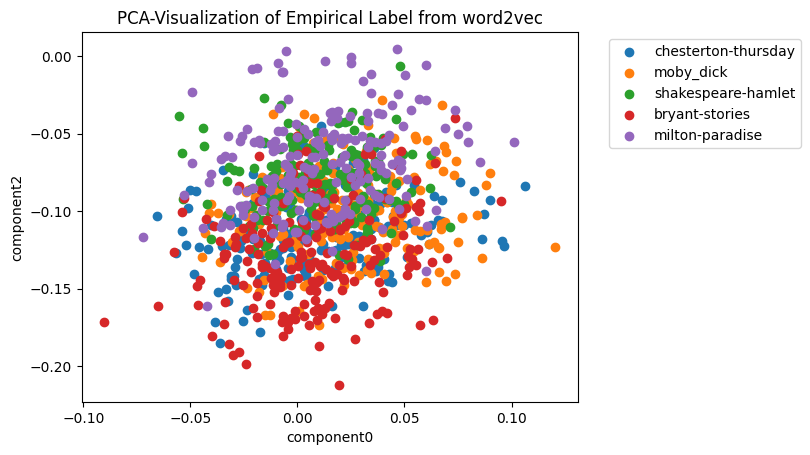

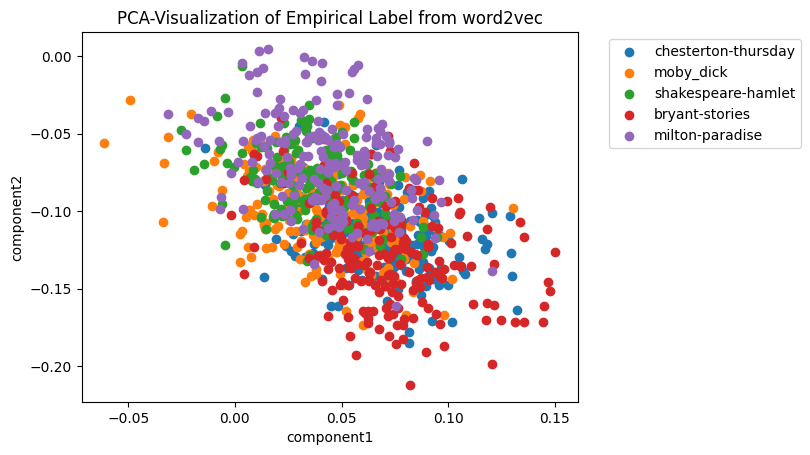

In [ ]:
word2vec_pca_visu=pd.DataFrame(x_word_2_vec)
word2vec_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
plot_empirical_clusters(0,1,word2vec_pca_visu,'PCA-Visualization of Empirical Label from word2vec')
plot_empirical_clusters(0,2,word2vec_pca_visu,'PCA-Visualization of Empirical Label from word2vec')
plot_empirical_clusters(1,2,word2vec_pca_visu,'PCA-Visualization of Empirical Label from word2vec')

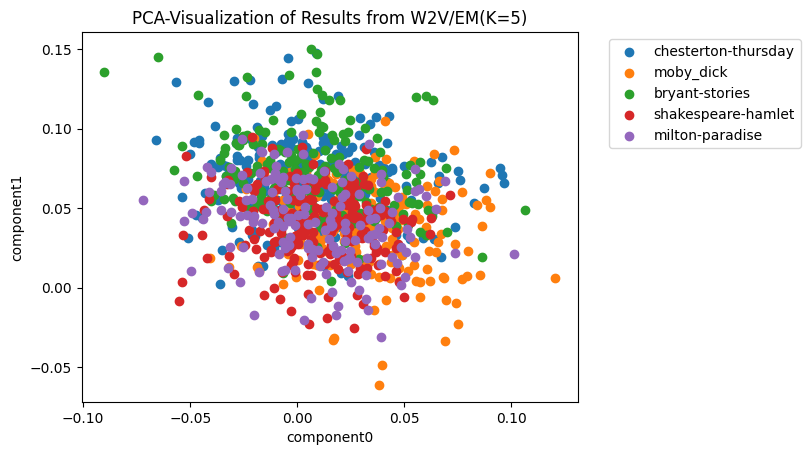

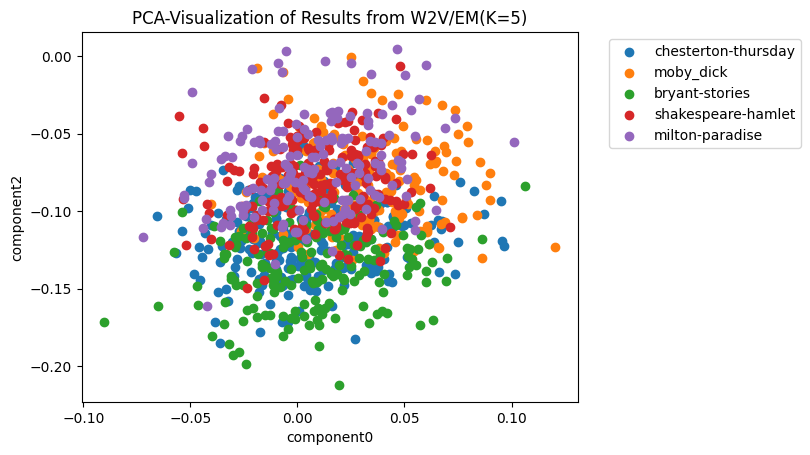

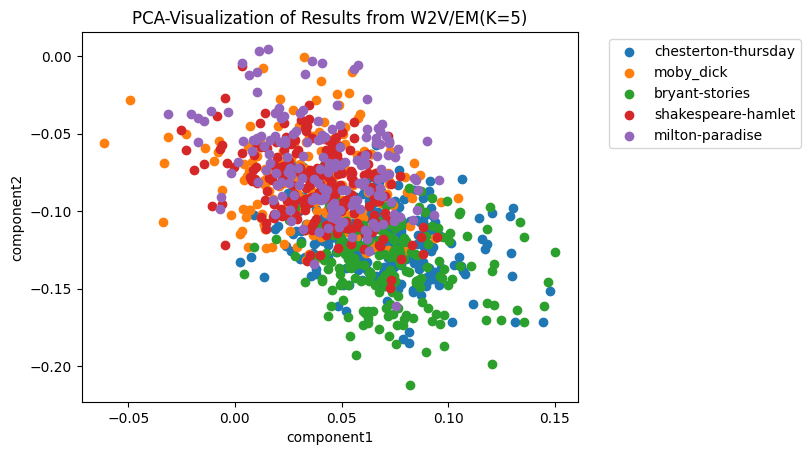

In [ ]:
word2vec_pca_visu=pd.DataFrame(x_word_2_vec)
word2vec_pca_visu[['cluster', 'empirical cluster', 'passage']]=y_correspond_label[['cluster', 'empirical cluster', 'passage']]
plot_clusters(0,1,word2vec_pca_visu,'PCA-Visualization of Results from W2V/EM(K=5)')
plot_clusters(0,2,word2vec_pca_visu,'PCA-Visualization of Results from W2V/EM(K=5)')
plot_clusters(1,2,word2vec_pca_visu,'PCA-Visualization of Results from W2V/EM(K=5)')

In [ ]:
len(return_list_ofErrors(y_correspond_label))

250

# Error analysis On K-Means with TFIDF/PCA

In [ ]:
k = 5
km = KMeans(n_clusters=k, init='k-means++',max_iter=200, n_init=10,random_state=42)
km.fit_predict(X_train_tfidf_pca)
pred_labels = km.labels_
TFIDF_KMeans_cluster=returnBookToCluster(df1,pred_labels)

In [ ]:
y_correspond_label=return_cluster_y_emp(TFIDF_KMeans_cluster,pred_labels,df1)

In [ ]:
y_correspond_label

cluster  ...                                            passage
0              moby_dick  ...  poet   -PRON- be really a poet who have become...
1    chesterton-thursday  ...  that when -PRON- break up rather hurriedly the...
2    chesterton-thursday  ...  as to send a lame man    -PRON- set off at a s...
3    chesterton-thursday  ...    gregory   upon the whole nature of poetry   ...
4    chesterton-thursday  ...  thread   -PRON- come nearer and near   the lam...
..                   ...  ...                                                ...
995      milton-paradise  ...  unexampled love   love no where to be find les...
996      milton-paradise  ...  then return at shut of evening flower   but   ...
997      milton-paradise  ...    to be deem a god   leap fondly into aetna fl...
998      milton-paradise  ...  -PRON- malice serve but to bring forth infinit...
999      milton-paradise  ...  the mouth of hell for ever   and seal up -PRON...

[1000 rows x 3 columns]

In [ ]:
errors=return_list_ofErrors(y_correspond_label)

In [ ]:
errors.groupby(by=['empirical cluster','cluster']).count().sort_values(by='passage',ascending=False)

passage
empirical cluster   cluster                     
chesterton-thursday moby_dick                 13
bryant-stories      moby_dick                  7
chesterton-thursday bryant-stories             4
moby_dick           bryant-stories             4
milton-paradise     moby_dick                  3
moby_dick           milton-paradise            3
bryant-stories      milton-paradise            2
                    chesterton-thursday        1

In [ ]:
errors

passage  ...    empirical cluster
0   poet   -PRON- be really a poet who have become...  ...  chesterton-thursday
1   honesty be the good policy    and virtue be -P...  ...  chesterton-thursday
2   to cross sword with the enemy of all creation ...  ...  chesterton-thursday
3   at the base of -PRON-   too deep even for -PRO...  ...  chesterton-thursday
4   the central seat   -PRON- be drape plainly   i...  ...  chesterton-thursday
5   the chair    this be approve by a show of hand...  ...  chesterton-thursday
6   the world -PRON-   why do a fly have to fight ...  ...  chesterton-thursday
7   the earth   -PRON- be still look at this dwind...  ...  chesterton-thursday
8   and that be childishness   be nt -PRON-    -PR...  ...  chesterton-thursday
9   the truth of the last tree and the topmost clo...  ...  chesterton-thursday
10  -PRON- learn about anarchist from ally sloper ...  ...  chesterton-thursday
11  -PRON- a time for ceremonial modesty   i set -...  ...  chesterton-thursday
12  face be so big   that one could nt focus -PRON...  ...  chesterton-thursday
13  contain gogol   and in faint hope of a clue or...  ...  chesterton-thursday
14  -PRON- find -PRON- in the presence of the grea...  ...  chesterton-thursday
15    truth out of tusitala speak and pleasure out...  ...  chesterton-thursday
16  as usual   quiet   courteous   rather gentle  ...  ...  chesterton-thursday
17     say i    if -PRON- have anything important ...  ...            moby_dick
18  then place the first bench lengthwise along th...  ...            moby_dick
19  must certainly have bring -PRON- ramadan to a ...  ...            moby_dick
20  -PRON- little room in the third floor   undres...  ...            moby_dick
21  -PRON- skull   mine eyeball ache and ache   -P...  ...            moby_dick
22  can say with -PRON- final breath   o father   ...  ...            moby_dick
23  divine spotlessness and power   by the persian...  ...            moby_dick
24  be spend the holiday   in the mental search fo...  ...       bryant-stories
25  of the big banquet hall -PRON- make -PRON- way...  ...       bryant-stories
26  -PRON- tail deep in the water   and give a mar...  ...       bryant-stories
27  the peculiarity of the ocean water and have fi...  ...       bryant-stories
28  now   and then -PRON- may learn -PRON-   to sa...  ...       bryant-stories
29  then frode shake from head to foot in -PRON- t...  ...       bryant-stories
30  _ and _ wealth   and -PRON- have the whole wor...  ...       bryant-stories
31  with -PRON- own greatness that -PRON- have no ...  ...       bryant-stories
32  -PRON- see that something be wrong   now i sha...  ...       bryant-stories
33  _ can _ -PRON- expect from a low   grovel beet...  ...       bryant-stories
34  mount casius old   where army whole have sink ...  ...      milton-paradise
35  dropt with gold   or   in -PRON- pearly shell ...  ...      milton-paradise
36  anon   while -PRON- discharge freely -PRON- pa...  ...      milton-paradise

[37 rows x 3 columns]

In [ ]:

moby_dic_chesterton_thursday=errors[(errors['cluster']=='moby_dick')&(errors['empirical cluster']=='chesterton-thursday')]['passage'].sum()


In [ ]:
len(moby_dic_chesterton_thursday)

10982

In [ ]:

def plot_unigram_bigram(corpus_test_highesterror,pred_title):
  lst_tokens = nltk.tokenize.word_tokenize(corpus_test_highesterror)
  dic_words_freq = nltk.FreqDist(lst_tokens)
  fig, ax = plt.subplots(nrows=1, ncols=2)
  fig.suptitle("Most frequent words in pred:"+pred_title, fontsize=15)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax[0], 
                    legend=False).grid(axis='x')
  ax[0].set(ylabel=None)

      
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                    string for string in x) )
  dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                    kind="barh", title="Bigrams", ax=ax[1],
                    legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.subplots_adjust(wspace=0.6,hspace=1,right=1)
  plt.show()
  fig.tight_layout(pad=10.0)

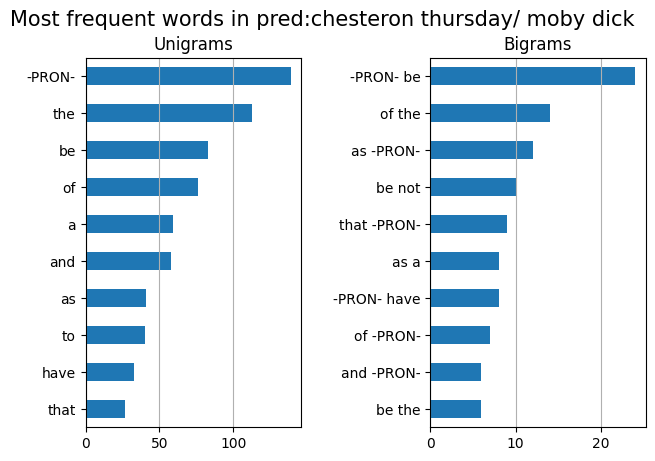

In [ ]:
plot_unigram_bigram(moby_dic_chesterton_thursday,'chesteron thursday/ moby dick ')

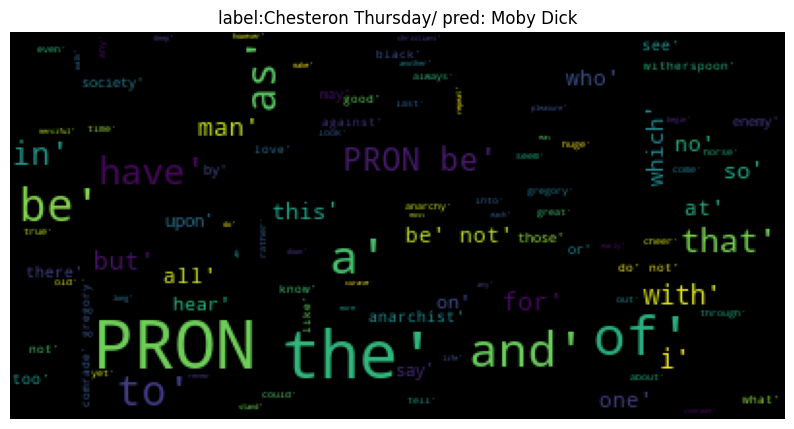

In [ ]:
wordc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wordc.generate(str(nltk.tokenize.word_tokenize(moby_dic_chesterton_thursday)))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('label:Chesteron Thursday/ pred: Moby Dick'	)
plt.show()

In [ ]:
moby_dic_bryantstories=errors[(errors['cluster']=='moby_dick')&(errors['empirical cluster']=='bryant-stories')]['passage'].sum()


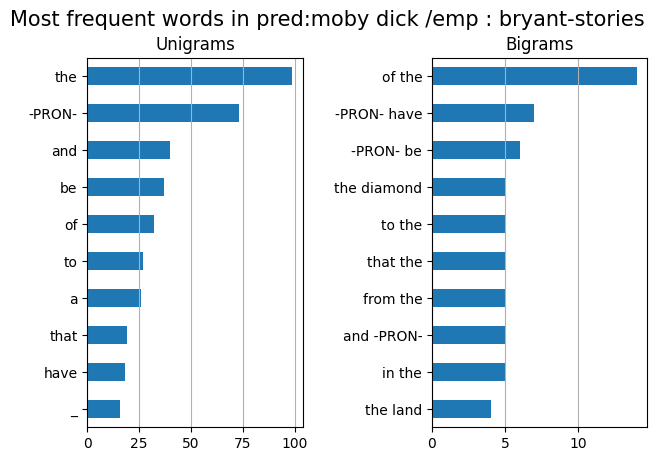

In [ ]:
plot_unigram_bigram(moby_dic_bryantstories,'moby dick /emp : bryant-stories')

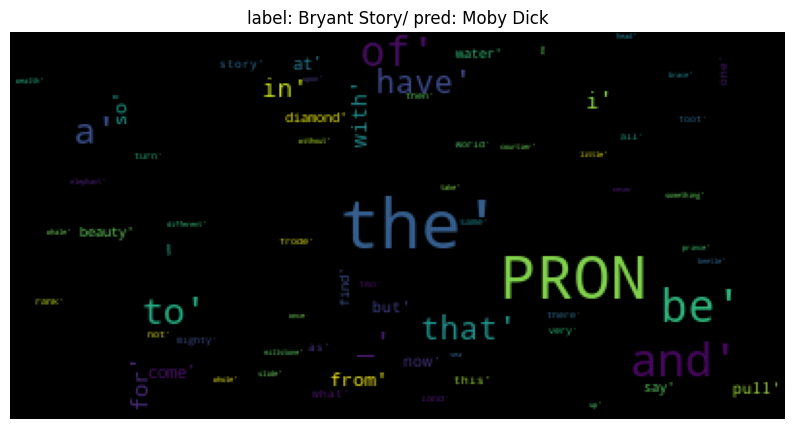

In [ ]:
wordc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wordc.generate(str(nltk.tokenize.word_tokenize(moby_dic_bryantstories)))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('label: Bryant Story/ pred: Moby Dick'	)
plt.show()

# Updated Feature Engineering With Stop words on Final Algorithm 

In [ ]:
spacy_nlp = spacy.load('en_core_web_lg') 

In [ ]:
def lemmatizationWithStopWords(x):
  X_list=[]
  for token in spacy_nlp(x):
    if( not token.is_stop ):
      lemma=token.lemma_ 
      X_list.append(lemma)
  return " ".join(X_list)

In [ ]:
df1=pd.read_excel('books.xlsx')

In [ ]:
df1['passage']=df1['passage'].apply(return_split)
df1['passage']=df1['passage'].apply(lemmatizationWithStopWords)
x=df1['passage']
y=df1['bookName']


In [ ]:
vec = TfidfVectorizer(binary=True, use_idf=True,min_df=0.01)
tfidf_train_data_updated = vec.fit_transform(x)  

In [ ]:
pca = PCA(n_components=300) 
X_train_tfidf_pca_withWordsTaken = pca.fit_transform(tfidf_train_data_updated.toarray()) 

In [ ]:
X_train_tfidf_pca_withWordsTaken

array([[-0.0378346 , -0.04451541, -0.02705271, ..., -0.03809488,
         0.06351554,  0.05083708],
       [-0.17377137, -0.19055122,  0.27156899, ...,  0.03906847,
        -0.03395688, -0.04500731],
       [-0.088754  , -0.06911355,  0.16558634, ...,  0.01722933,
        -0.00762516,  0.01175344],
       ...,
       [-0.07951403,  0.08962887, -0.01475857, ...,  0.06313217,
         0.01476831,  0.05537173],
       [-0.02756394,  0.15730084, -0.01464659, ..., -0.00816205,
         0.00916093,  0.00996754],
       [-0.00655407,  0.24740007, -0.01504312, ...,  0.02820291,
        -0.00192477, -0.01241983]])

In [ ]:
k = 5
km = KMeans(n_clusters=k, init='k-means++',max_iter=200, n_init=10,random_state=42)
km.fit_predict(X_train_tfidf_pca_withWordsTaken)
pred_labels= km.labels_

In [ ]:
TFIDF_stopwords_KMeans_cluster=returnBookToCluster(df1,pred_labels)
TFIDF_stopwords_KMeans_cluster

bryant-stories  chesterton-thursday  ...  clusterNum        cluster_label
0             188                    8  ...           1       bryant-stories
1               1                  183  ...           4  chesterton-thursday
2               5                    5  ...           3      milton-paradise
3               6                    4  ...           0            moby_dick
4               0                    0  ...           2   shakespeare-hamlet

[5 rows x 7 columns]

In [ ]:
y_correspond_label=return_cluster_y_emp(TFIDF_stopwords_KMeans_cluster,pred_labels,df1)
errors=return_list_ofErrors(y_correspond_label)

In [ ]:
len(errors)

51

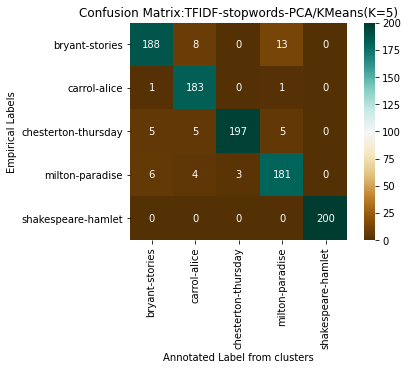

In [ ]:
 plot_confusion_matrix(y_correspond_label['cluster'],y_correspond_label['empirical cluster'],'TFIDF-stopwords-PCA/KMeans(K=5)')

In [ ]:
errors.groupby(by=['empirical cluster','cluster']).count().sort_values(by='passage',ascending=False)

passage
empirical cluster   cluster                     
moby_dick           bryant-stories            13
chesterton-thursday bryant-stories             8
bryant-stories      moby_dick                  6
                    milton-paradise            5
chesterton-thursday milton-paradise            5
moby_dick           milton-paradise            5
chesterton-thursday moby_dick                  4
milton-paradise     moby_dick                  3
bryant-stories      chesterton-thursday        1
moby_dick           chesterton-thursday        1

In [ ]:

moby_dic_byrant_story=errors[(errors['cluster']=='moby_dick')&(errors['empirical cluster']=='bryant-stories')]['passage'].sum()


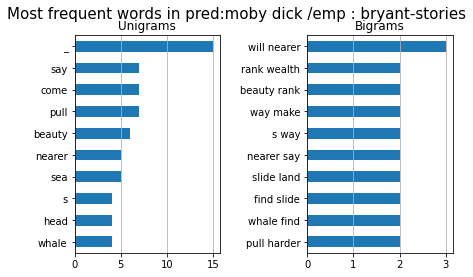

In [ ]:
plot_unigram_bigram(moby_dic_byrant_story,'moby dick /emp : bryant-stories')

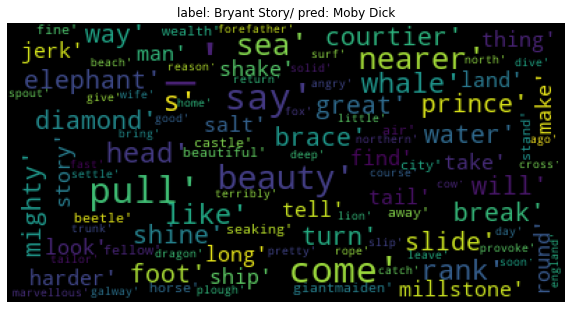

In [ ]:
wordc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wordc.generate(str(nltk.tokenize.word_tokenize(moby_dic_byrant_story)))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('label: Bryant Story/ pred: Moby Dick'	)
plt.show()

In [ ]:
cohen_kappa_score(y_correspond_label['empirical cluster'],y_correspond_label['cluster'])

0.93625